# Play w predict scripts

In [10]:
!ls ../extra_space/test_pics/01rFQwp0fqXLHg33/

0001.jpg  0244.jpg  0487.jpg  0730.jpg	0973.jpg  1216.jpg  1459.jpg  1702.jpg
0002.jpg  0245.jpg  0488.jpg  0731.jpg	0974.jpg  1217.jpg  1460.jpg  1703.jpg
0003.jpg  0246.jpg  0489.jpg  0732.jpg	0975.jpg  1218.jpg  1461.jpg  1704.jpg
0004.jpg  0247.jpg  0490.jpg  0733.jpg	0976.jpg  1219.jpg  1462.jpg  1705.jpg
0005.jpg  0248.jpg  0491.jpg  0734.jpg	0977.jpg  1220.jpg  1463.jpg  1706.jpg
0006.jpg  0249.jpg  0492.jpg  0735.jpg	0978.jpg  1221.jpg  1464.jpg  1707.jpg
0007.jpg  0250.jpg  0493.jpg  0736.jpg	0979.jpg  1222.jpg  1465.jpg  1708.jpg
0008.jpg  0251.jpg  0494.jpg  0737.jpg	0980.jpg  1223.jpg  1466.jpg  1709.jpg
0009.jpg  0252.jpg  0495.jpg  0738.jpg	0981.jpg  1224.jpg  1467.jpg  1710.jpg
0010.jpg  0253.jpg  0496.jpg  0739.jpg	0982.jpg  1225.jpg  1468.jpg  1711.jpg
0011.jpg  0254.jpg  0497.jpg  0740.jpg	0983.jpg  1226.jpg  1469.jpg  1712.jpg
0012.jpg  0255.jpg  0498.jpg  0741.jpg	0984.jpg  1227.jpg  1470.jpg  1713.jpg
0013.jpg  0256.jpg  0499.jpg  0742.jpg	0985.jpg  1228.jpg  1471.

In [5]:
def read_frame(video_id,frame,input_size):
    try:
        img = cv2.imread('../extra_space/test_pics/{}/{}.jpg'.format(video_id,str(frame+1).zfill(4)))
        img = cv2.resize(img, (input_size, input_size))
    except Exception as e:
        img = np.random.rand(input_size,input_size,3)
        print (str(e))
        print('Error with loading ../extra_space/test_pics/{}/{}.jpg'.format(video_id,str(frame+1).zfill(4)))
                
    return img

In [6]:
ids_test[0]

{'frame': 0, 'row_id': 0, 'video_id': '01rFQwp0fqXLHg33'}

In [10]:
import numpy as np
import cv2

img = read_frame(ids_test[0]['video_id'],ids_test[0]['frame'],300)


In [84]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
from data import VOCroot
from data import VOC_CLASSES as labelmap
import torch.utils.data as data

from data import AnnotationTransform, VOCDetection, BaseTransform, VOC_CLASSES
from ssd import build_ssd
import pandas as pd

import sys
import os
import time
import argparse
import numpy as np
import pickle
import cv2
from data import FISHdetection
import tqdm 

from data import detection_collate
from utils.augmentations import SSDAugmentation_predict

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

ssd_dim = 300  # only support 300 now
means = (104, 117, 123)  # only support voc now

broken_vids = ['P3QkoeOjxoM6pDKb','tJinkrdMMZ477RGi']

df_sub = pd.read_csv('../fish-video/submission.csv')
df_sub.head()

df_sub['xmin'] = 0
df_sub['xmax'] = 0
df_sub['ymin'] = 0
df_sub['ymax'] = 0

ids_test = [{'row_id':row[0],'frame':row[1],'video_id':row[2]} 
            for row in df_sub[(~df_sub.video_id.isin(broken_vids))][['row_id','frame','video_id']].values]

image_paths = [('../extra_space/test_pics/{}/{}.jpg'.format(frame['video_id'],str(frame['frame']+1).zfill(4))) for frame in ids_test]
image_annots = [([0.1,0.1,0.2,0.2,1.0]) for path in image_paths]

"""
parser = argparse.ArgumentParser(description='Single Shot MultiBox Detection')
parser.add_argument('--trained_model', default='weights/ssd300_mAP_77.43_v2.pth',
                    type=str, help='Trained state_dict file path to open')
parser.add_argument('--save_folder', default='eval/', type=str,
                    help='File path to save results')
parser.add_argument('--confidence_threshold', default=0.01, type=float,
                    help='Detection confidence threshold')
parser.add_argument('--top_k', default=5, type=int,
                    help='Further restrict the number of predictions to parse')
parser.add_argument('--cuda', default=True, type=str2bool,
                    help='Use cuda to train model')
parser.add_argument('--voc_root', default=VOCroot, help='Location of VOC root directory')

args = parser.parse_args()
"""
args = type('test', (), {})()
args.cuda = True

if args.cuda and torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')


LABELS = ['species_fourspot',
           'species_grey sole',
           'species_other', 
           'species_plaice',
           'species_summer',
           'species_windowpane',
           'species_winter']

dataset_mean = (104, 117, 123)

# load net
num_classes = len(LABELS) + 1 # +1 background

args.trained_model = 'weights/ssd_fish75000.pth'
args.num_workers = 4

ssd_net = build_ssd('test', 300, num_classes)
net = ssd_net

if args.cuda:
    net = torch.nn.DataParallel(ssd_net)
    cudnn.benchmark = True


ssd_net.load_weights(args.trained_model)

if args.cuda:
    net = net.cuda()
    
net.eval()

print('Finished loading model!')
# load data
dataset = FISHdetection(image_paths=image_paths,
                        image_annots=image_annots,
                        transform=SSDAugmentation_predict(ssd_dim, means),
                        dataset_name='fish_detection')
batch_size = 16

data_loader = data.DataLoader(dataset,
                              batch_size,
                              num_workers=args.num_workers,
                              shuffle=False,
                              collate_fn=detection_collate,
                              pin_memory=True)    


Loading weights into state dict...
Finished!
Finished loading model!


In [85]:
for i, (input, target) in enumerate(data_loader):
    input_var = torch.autograd.Variable(input, volatile=True)
  
    output = net(input_var)

    print(i)
    break
            

AttributeError: 'torch.cuda.FloatTensor' object has no attribute 'expand_'

In [81]:
output[3].size()

IndexError: tuple index out of range

In [27]:
output[1].data


( 0  ,.,.) = 
  8.6955e+00 -4.2130e+00 -4.1309e+00  ...  -4.7818e+00 -2.7103e+00 -4.3287e+00
  8.4072e+00 -4.9608e+00 -4.4611e+00  ...  -4.6492e+00 -3.2674e+00 -4.6041e+00
  8.3016e+00 -3.3383e+00 -2.8462e+00  ...  -2.8576e+00 -2.6228e+00 -2.4500e+00
                 ...                   ⋱                   ...                
  1.4612e+01 -1.7204e+00 -3.9737e+00  ...   4.3161e-01  7.1634e-01 -2.7869e+00
  1.3925e+01 -6.3353e-01 -4.4164e+00  ...   1.6093e+00  1.3677e+00 -2.8469e+00
  1.5366e+01 -3.0517e-02 -5.3746e+00  ...   1.1251e-01  3.3583e-01 -1.4904e+00

( 1  ,.,.) = 
  8.5334e+00 -4.0817e+00 -4.0715e+00  ...  -4.8397e+00 -2.7430e+00 -4.3841e+00
  8.5231e+00 -4.8974e+00 -4.4810e+00  ...  -4.7535e+00 -3.3719e+00 -4.6412e+00
  8.1983e+00 -3.2665e+00 -2.7939e+00  ...  -2.8925e+00 -2.5805e+00 -2.5208e+00
                 ...                   ⋱                   ...                
  1.4708e+01 -1.7338e+00 -4.0011e+00  ...   4.3462e-01  7.2444e-01 -2.8048e+00
  1.4019e+01 -6.3933e-

In [18]:
net(input_var[0].unsqueeze(0))

(Variable containing:
 ( 0  ,.,.) = 
  -5.1631e-01  1.0615e+00 -1.6925e+00 -6.3368e-01
  -2.0139e-01  1.2576e+00 -9.8816e-01  6.1912e-01
  -7.0055e-01  3.4868e-01 -2.9269e+00 -6.3576e-01
                        ⋮                        
   7.0915e-01  6.4269e-01 -6.5986e+00 -1.9990e+00
   4.6640e-02  6.5011e-01 -5.7412e+00 -9.4922e-01
   4.7752e-01  2.2758e-01 -2.2504e+00 -5.3543e+00
 [torch.cuda.FloatTensor of size 1x8732x4 (GPU 0)], Variable containing:
 ( 0  ,.,.) = 
   8.6955e+00 -4.2130e+00 -4.1309e+00  ...  -4.7818e+00 -2.7103e+00 -4.3287e+00
   8.4072e+00 -4.9608e+00 -4.4611e+00  ...  -4.6492e+00 -3.2674e+00 -4.6041e+00
   8.3016e+00 -3.3383e+00 -2.8462e+00  ...  -2.8576e+00 -2.6228e+00 -2.4500e+00
                  ...                   ⋱                   ...                
   1.4612e+01 -1.7204e+00 -3.9737e+00  ...   4.3161e-01  7.1634e-01 -2.7869e+00
   1.3925e+01 -6.3353e-01 -4.4164e+00  ...   1.6093e+00  1.3677e+00 -2.8469e+00
   1.5366e+01 -3.0517e-02 -5.3746e+00  ...   

In [15]:
.size()

torch.Size([1, 3, 300, 300])

In [11]:
output.data

AttributeError: 'tuple' object has no attribute 'data'

In [10]:
input_var = input_var.cuda()

In [16]:
net.is_cuda


AttributeError: 'DataParallel' object has no attribute 'is_cuda'

In [22]:
input_var.size()

torch.Size([16, 3, 300, 300])

In [29]:
net.is_cuda

AttributeError: 'DataParallel' object has no attribute 'is_cuda'

RuntimeError: expected CPU tensor (got CUDA tensor)

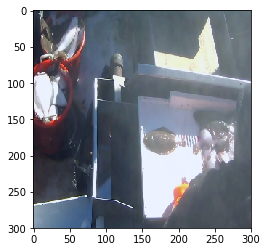

In [13]:
import matplotlib.pyplot as plt

img = images[0].cpu().numpy().astype(np.float32).transpose((1, 2, 0))
img += -img.min()
img *= (1/img.max())

plt.imshow(img)
plt.show()

In [12]:
images.size()

torch.Size([16, 3, 300, 300])

In [3]:
!ls ../extra_space/test_pics/01rFQwp0fqXLHg33/0001.jpg

../extra_space/test_pics/01rFQwp0fqXLHg33/0001.jpg


In [2]:
image_paths[0]

'../extra_space/test_pics/01rFQwp0fqXLHg33/0001.jpg'

In [2]:
args.num_workers

4

In [6]:
len(ids_test)

917819

In [7]:
len(image_paths)

917819

In [ ]:
dataset = VOCDetection(args.voc_root, [('2007', set_type)], BaseTransform(300, dataset_mean), AnnotationTransform())

In [19]:
i = 0

im, gt, h, w = dataset.pull_item(i)
x = Variable(im.unsqueeze(0))

if args.cuda:
    x = x.cuda()

detections = net(x).data
   

AttributeError: 'tuple' object has no attribute 'data'

In [58]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
from data import VOCroot
from data import VOC_CLASSES as labelmap
import torch.utils.data as data

from data import AnnotationTransform, VOCDetection, BaseTransform, VOC_CLASSES
from ssd import build_ssd
import pandas as pd

import sys
import os
import time
import argparse
import numpy as np
import pickle
import cv2
from data import FISHdetection
import tqdm 

from data import detection_collate
from utils.augmentations import SSDAugmentation_predict

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

ssd_dim = 300  # only support 300 now
means = (104, 117, 123)  # only support voc now

broken_vids = ['P3QkoeOjxoM6pDKb','tJinkrdMMZ477RGi']

df_sub = pd.read_csv('../fish-video/submission.csv')
df_sub.head()

df_sub['xmin'] = 0
df_sub['xmax'] = 0
df_sub['ymin'] = 0
df_sub['ymax'] = 0

ids_test = [{'row_id':row[0],'frame':row[1],'video_id':row[2]} 
            for row in df_sub[(~df_sub.video_id.isin(broken_vids))][['row_id','frame','video_id']].values]

image_paths = [('../extra_space/test_pics/{}/{}.jpg'.format(frame['video_id'],str(frame['frame']+1).zfill(4))) for frame in ids_test]
image_annots = [([0.1,0.1,0.2,0.2,1.0]) for path in image_paths]

"""
parser = argparse.ArgumentParser(description='Single Shot MultiBox Detection')
parser.add_argument('--trained_model', default='weights/ssd300_mAP_77.43_v2.pth',
                    type=str, help='Trained state_dict file path to open')
parser.add_argument('--save_folder', default='eval/', type=str,
                    help='File path to save results')
parser.add_argument('--confidence_threshold', default=0.01, type=float,
                    help='Detection confidence threshold')
parser.add_argument('--top_k', default=5, type=int,
                    help='Further restrict the number of predictions to parse')
parser.add_argument('--cuda', default=True, type=str2bool,
                    help='Use cuda to train model')
parser.add_argument('--voc_root', default=VOCroot, help='Location of VOC root directory')

args = parser.parse_args()
"""
args = type('test', (), {})()
args.cuda = True

LABELS = ['species_fourspot',
           'species_grey sole',
           'species_other', 
           'species_plaice',
           'species_summer',
           'species_windowpane',
           'species_winter']

dataset_mean = (104, 117, 123)

# load net
num_classes = len(LABELS) + 1 # +1 background

net = build_ssd('train', 300, num_classes)

args.trained_model = 'weights/ssd_fish75000.pth'
args.num_workers = 4

net = build_ssd('test', 300, num_classes) # initialize SSD
net.load_state_dict(torch.load(args.trained_model))
net.eval()

if args.cuda:
    net = net.cuda()
    cudnn.benchmark = True
    
net.eval()

print('Finished loading model!')
# load data
dataset = FISHdetection(image_paths=image_paths,
                        image_annots=image_annots,
                        transform=SSDAugmentation_predict(ssd_dim, means),
                        dataset_name='fish_detection')

# all detections are collected into:
#    all_boxes[cls][image] = N x 5 array of detections in
#    (x1, y1, x2, y2, score)
all_boxes = [[[] for _ in range(len(ids_test))]
             for _ in range(len(LABELS)+1)]

with tqdm.tqdm(total=10) as pbar:
    # for i in range(len(ids_test)):
    for i in range(10):    
        im, gt, h, w = dataset.pull_item(i)
        x = Variable(im.unsqueeze(0))

        if args.cuda:
            x = x.cuda()

        detections = net(x).data

        # skip j = 0, because it's the background class    
        for j in range(1, detections.size(1)):
            dets = detections[0, j, :]
            mask = dets[:, 0].gt(0.).expand(5, dets.size(0)).t()     
            dets = torch.masked_select(dets, mask).view(-1, 5)
            if dets.dim() == 0:
                continue        
            boxes = dets[:, 1:]
            boxes[:, 0] *= w
            boxes[:, 2] *= w
            boxes[:, 1] *= h
            boxes[:, 3] *= h    
            scores = dets[:, 0].cpu().numpy()
            cls_dets = np.hstack((boxes.cpu().numpy(), scores[:, np.newaxis])) \
                .astype(np.float32, copy=False)
            all_boxes[j][i] = cls_dets      
            
        pbar.update(1)
        
np.save('fish_ssd_preds_test',all_boxes)

Finished loading model!


100%|██████████| 10/10 [00:02<00:00,  1.36s/it]


In [70]:
for i in [143269]:
    try:
        im, gt, h, w = dataset.pull_item(i)
        x = Variable(im.unsqueeze(0))

        if args.cuda:
            x = x.cuda()

        detections = net(x).data

        # skip j = 0, because it's the background class    
        for j in range(1, detections.size(1)):
            dets = detections[0, j, :]
            mask = dets[:, 0].gt(0.).expand(5, dets.size(0)).t()     
            dets = torch.masked_select(dets, mask).view(-1, 5)
            if dets.dim() == 0:
                continue        
            boxes = dets[:, 1:]
            boxes[:, 0] *= w
            boxes[:, 2] *= w
            boxes[:, 1] *= h
            boxes[:, 3] *= h    
            scores = dets[:, 0].cpu().numpy()
            cls_dets = np.hstack((boxes.cpu().numpy(), scores[:, np.newaxis])) \
                .astype(np.float32, copy=False)
            all_boxes[j][i] = cls_dets
    except Exception as e:
        print()
        print('{} was triggered on item {}'.format(str(e), i))

    pbar.update(1)


'NoneType' object has no attribute 'shape' was triggered on item 143269


In [66]:
!ls ../extra_space/test_pics/8jkQWJWPCtIvcnmH/1130.jpg

ls: cannot access '../extra_space/test_pics/8jkQWJWPCtIvcnmH/1130.jpg': No such file or directory


In [64]:
dataset.image_paths[143269]

'../extra_space/test_pics/8jkQWJWPCtIvcnmH/1130.jpg'

In [62]:
im, gt, h, w = dataset.pull_item(143269)

AttributeError: 'NoneType' object has no attribute 'shape'

In [10]:
len(ids_test)

917819

In [9]:
len(all_boxes[0])

917819

In [3]:
detections.size()

torch.Size([1, 8, 200, 5])

In [4]:
# all detections are collected into:
#    all_boxes[cls][image] = N x 5 array of detections in
#    (x1, y1, x2, y2, score)
all_boxes = [[[] for _ in range(len(ids_test))]
             for _ in range(len(LABELS)+1)]

with tqdm.tqdm(total=1000) as pbar:
    # for i in range(len(ids_test)):
    for i in range(1000):    
        im, gt, h, w = dataset.pull_item(i)
        x = Variable(im.unsqueeze(0))

        if args.cuda:
            x = x.cuda()

        detections = net(x).data

        # skip j = 0, because it's the background class    
        for j in range(1, detections.size(1)):
            dets = detections[0, j, :]
            mask = dets[:, 0].gt(0.).expand(5, dets.size(0)).t()     
            dets = torch.masked_select(dets, mask).view(-1, 5)
            if dets.dim() == 0:
                continue        
            boxes = dets[:, 1:]
            boxes[:, 0] *= w
            boxes[:, 2] *= w
            boxes[:, 1] *= h
            boxes[:, 3] *= h    
            scores = dets[:, 0].cpu().numpy()
            cls_dets = np.hstack((boxes.cpu().numpy(), scores[:, np.newaxis])) \
                .astype(np.float32, copy=False)
            all_boxes[j][i] = cls_dets      
            
        pbar.update(1)

100%|██████████| 1000/1000 [00:22<00:00, 43.48it/s]


7

In [13]:
len(all_boxes[0])

917819

In [50]:
cls_dets

array([[  6.46656799e+02,   3.04545746e+02,   8.95909424e+02,
          5.53331543e+02,   5.02362996e-02]], dtype=float32)

In [27]:
dets.size()

torch.Size([200, 5])

In [28]:
mask = dets[:, 0].gt(0.).expand(5, dets.size(0)).t()

In [29]:
mask


    1     1     1     1     1
    0     0     0     0     0
    0     0     0     0     0
              ⋮               
    0     0     0     0     0
    0     0     0     0     0
    0     0     0     0     0
[torch.ByteTensor of size 200x5]

In [ ]:

        dets = torch.masked_select(dets, mask).view(-1, 5)
        if dets.dim() == 0:
            continue
        boxes = dets[:, 1:]
        boxes[:, 0] *= w
        boxes[:, 2] *= w
        boxes[:, 1] *= h
        boxes[:, 3] *= h
        scores = dets[:, 0].cpu().numpy()
        cls_dets = np.hstack((boxes.cpu().numpy(), scores[:, np.newaxis])) \
            .astype(np.float32, copy=False)
        all_boxes[j][i] = cls_dets  

In [24]:
detections.size()

torch.Size([1, 8, 200, 5])

In [18]:
im.unsqueeze(0).size()

torch.Size([1, 3, 300, 300])

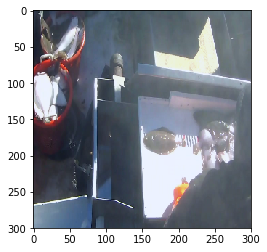

In [14]:
import matplotlib.pyplot as plt

img = im.cpu().numpy().astype(np.float32).transpose((1, 2, 0))
img += -img.min()
img *= (1/img.max())

plt.imshow(img)
plt.show()

In [ ]:
def test_net(save_folder, net, cuda, dataset, transform, top_k,
             im_size=300, thresh=0.05):
    """Test a Fast R-CNN network on an image database."""
    num_images = len(dataset)
    # all detections are collected into:
    #    all_boxes[cls][image] = N x 5 array of detections in
    #    (x1, y1, x2, y2, score)
    all_boxes = [[[] for _ in range(num_images)]
                 for _ in range(len(labelmap)+1)]

    # timers
    _t = {'im_detect': Timer(), 'misc': Timer()}
    output_dir = get_output_dir('ssd300_120000', set_type)
    det_file = os.path.join(output_dir, 'detections.pkl')

    for i in range(num_images):
        im, gt, h, w = dataset.pull_item(i)

        x = Variable(im.unsqueeze(0))
        if args.cuda:
            x = x.cuda()
        _t['im_detect'].tic()
        detections = net(x).data
        detect_time = _t['im_detect'].toc(average=False)

        # skip j = 0, because it's the background class
        for j in range(1, detections.size(1)):
            dets = detections[0, j, :]
            mask = dets[:, 0].gt(0.).expand(5, dets.size(0)).t()
            dets = torch.masked_select(dets, mask).view(-1, 5)
            if dets.dim() == 0:
                continue
            boxes = dets[:, 1:]
            boxes[:, 0] *= w
            boxes[:, 2] *= w
            boxes[:, 1] *= h
            boxes[:, 3] *= h
            scores = dets[:, 0].cpu().numpy()
            cls_dets = np.hstack((boxes.cpu().numpy(), scores[:, np.newaxis])) \
                .astype(np.float32, copy=False)
            all_boxes[j][i] = cls_dets

        print('im_detect: {:d}/{:d} {:.3f}s'.format(i + 1,
                                                    num_images, detect_time))

    with open(det_file, 'wb') as f:
        pickle.dump(all_boxes, f, pickle.HIGHEST_PROTOCOL)

    print('Evaluating detections')
    evaluate_detections(all_boxes, output_dir, dataset)


# Load predict script into df and do manual cleaning

## Pre-process predictions

In [142]:
import pandas as pd
import numpy as np
import operator


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")
def extract_value(arr):
    try:
        return arr[0][4]
    except:
        return 0
def extract_coords(arr):
    try:
        return arr[0][4]
    except:
        return 0
def get_best_frame(index):
    
    frame_list = []
    prob_list = []

    for i in range(1,8):
        try:
            prob_list.append(data[i][index][0][4])
            frame_list.append(data[i][index][0][0:4])
        except:
            continue
    try:
        index, value = max(enumerate(prob_list), key=operator.itemgetter(1))
        return (frame_list[index])
    except:
        return (0,0,0,0)
    

LABELS = ['species_fourspot',
           'species_grey sole',
           'species_other', 
           'species_plaice',
           'species_summer',
           'species_windowpane',
           'species_winter']


broken_vids = ['P3QkoeOjxoM6pDKb','tJinkrdMMZ477RGi']

df_sub = pd.read_csv('../fish-video/submission.csv')

df_sub['xmin'] = 0
df_sub['xmax'] = 0
df_sub['ymin'] = 0
df_sub['ymax'] = 0

ids_test = [{'row_id':row[0],'frame':row[1],'video_id':row[2]} 
            for row in df_sub[(~df_sub.video_id.isin(broken_vids))][['row_id','frame','video_id']].values]

image_paths = [('../extra_space/test_pics/{}/{}.jpg'.format(frame['video_id'],str(frame['frame']+1).zfill(4))) for frame in ids_test]

data = np.load('fish_ssd_preds.npy')

# Extract fish scores
for i,label in zip(range(1,8),LABELS):
    df_sub.loc[idx_list,label] = [(extract_value(pred)) for pred in data[i]]

# Extract best frame coords as per most likely class
frame_list = [get_best_frame(ind) for ind, x in enumerate(data[1])]    
df_sub.loc[idx_list,['xmin','ymin','xmax','ymax']] = frame_list

df_sub.to_csv('fish_ssd_v1.csv')

In [48]:
df_sub = pd.read_csv('../fish-video/submission.csv')

In [49]:
df_sub

,row_id,frame,video_id,fish_number,length,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter
0,0,0,01rFQwp0fqXLHg33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,01rFQwp0fqXLHg33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,01rFQwp0fqXLHg33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3,01rFQwp0fqXLHg33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,01rFQwp0fqXLHg33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,5,01rFQwp0fqXLHg33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,6,01rFQwp0fqXLHg33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,7,01rFQwp0fqXLHg33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,8,01rFQwp0fqXLHg33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,9,01rFQwp0fqXLHg33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
from IPython.display import FileLink

FileLink('fish_ssd_v1.csv')

/home/keras/notebook/ssd.pytorch/fish_ssd_v1.csv

## Create some test videos

In [144]:
df_test = pd.read_csv('../fish-video/fish_vector_test_10.csv')
df_test.head()

,Unnamed: 0,Unnamed: 0.1,row_id,frame,video_id,fish_number,length,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter,xmin,xmax,ymin,ymax
0,697432,697432,697432,0,l31ndpFRLM7ozY3H,0.0,0.0,0.0,0.000000,0.0,0.970845,0.0,0.0,0.0,89,139,316,404
1,697433,697433,697433,1,l31ndpFRLM7ozY3H,0.0,0.0,0.0,0.000000,0.0,0.957923,0.0,0.0,0.0,90,140,315,404
2,697434,697434,697434,2,l31ndpFRLM7ozY3H,0.0,0.0,0.0,0.000000,0.0,0.965748,0.0,0.0,0.0,90,140,315,404
3,697435,697435,697435,3,l31ndpFRLM7ozY3H,0.0,0.0,0.0,0.000000,0.0,0.965337,0.0,0.0,0.0,90,140,315,404
4,697436,697436,697436,4,l31ndpFRLM7ozY3H,0.0,0.0,0.0,0.156341,0.0,0.819681,0.0,0.0,0.0,89,139,314,404


In [154]:
def read_frame(video_id,frame):
    try:
        img = cv2.imread('../extra_space/test_pics/{}/{}.jpg'.format(video_id,str(frame+1).zfill(4)))
        # img = cv2.resize(img, (input_size, input_size))
    except:
        img = np.random.rand(input_size,input_size,3)
        
    return img

In [160]:
!ls ../fish-video/inspect_vids/live_model_test/01rFQwp0fqXLHg33_0001.jpg

../fish-video/inspect_vids/live_model_test/01rFQwp0fqXLHg33_0001.jpg


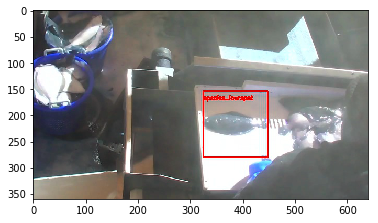

In [162]:
import matplotlib.pyplot as plt

img = cv2.imread('../fish-video/inspect_vids/live_model_test/01rFQwp0fqXLHg33_0001.jpg')
plt.imshow(img)
plt.show()

In [186]:
import pandas as pd
import cv2
import numpy as np
import pandas as pd
import threading
import queue
# import tensorflow as tf
from tqdm import tqdm
from random import shuffle
from multiprocessing.dummy import Pool as ThreadPool 


species_list = ['species_fourspot', 'species_grey sole','species_other', 'species_plaice', 'species_summer','species_windowpane', 'species_winter']

df_test = pd.read_csv('fish_ssd_v1.csv')
video_id = '01rFQwp0fqXLHg33'
input_size = 416

THRESHOLD = 0.5

df_test.loc[df_test[species_list].sum(axis=1)<THRESHOLD, species_list+['xmin','ymin','xmax','ymax']] = 0

def read_frame(video_id,frame,input_size):
    try:
        img = cv2.imread('../extra_space/test_pics/{}/{}.jpg'.format(video_id,str(frame+1).zfill(4)))
        img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
    except:
        img = np.random.rand(input_size,input_size,3)
        
    return img

def draw_box(image,xmin,ymin,xmax,ymax,label):
    
    xmin,xmax = int(xmin/2),int(xmax/2)
    ymin,ymax = int(ymin/2),int(ymax/2)
    
    cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (255,0,0), 2)
    cv2.putText(image, label, 
                (xmin, ymin + 16), 
                0, 
                1e-3 * image.shape[0], 
                (255,0,0), 2)
        
    return image 

ids_test = [{'row_id':row[0],'frame':row[1],'video_id':row[2]} 
            for row in df_test[df_test.video_id == video_id][['row_id','frame','video_id']].values]

with tqdm(total=len(ids_test)) as pbar:

    for frame_id in ids_test:
        img = read_frame(frame_id['video_id'],frame_id['frame'],input_size)

        data = df_test[(df_test.video_id==frame_id['video_id'])&(df_test.frame == frame_id['frame'])][['xmin','ymin','xmax','ymax']].values 

        if data[0].shape[0]>0:
            label = df_test[(df_test.video_id == frame_id['video_id']) & (df_test.frame == frame_id['frame'])][species_list].values.argmax()
            label = species_list[label]    
            img = draw_box(img,int(data[0][0]),int(data[0][1]),int(data[0][2]),int(data[0][3]),label)

        cv2.imwrite('../fish-video/inspect_vids/live_model_test/{}_{}.jpg'.format(frame_id['video_id'],str(frame_id['frame']+1).zfill(4) ),img)

        pbar.update(1)
        
import os
import glob

g = glob.glob('../fish-video/inspect_vids/live_model_test/*.jpg')
vids = set([gl.split('/')[4].split('_')[0] for gl in g])

for vid in vids:
    images = '../fish-video/inspect_vids/live_model_test/{}_%04d.jpg'.format(vid)
    target_vid = '../fish-video/inspect_vids/live_model_test/{}.mp4'.format(vid)
    !ffmpeg -loglevel quiet -f image2 -framerate 25 -i $images $target_vid
    

100%|██████████| 1944/1944 [05:00<00:00,  7.25it/s]


File '../fish-video/inspect_vids/live_model_test/01rFQwp0fqXLHg33.mp4' already exists. Overwrite ? [y/N] ^C


In [188]:
!rm ../fish-video/inspect_vids/live_model_test/01rFQwp0fqXLHg33.mp4

In [176]:
vids

{'01rFQwp0fqXLHg33'}

In [189]:
import os
import glob

g = glob.glob('../fish-video/inspect_vids/live_model_test/*.jpg')
vids = set([gl.split('/')[4].split('_')[0] for gl in g])

for vid in vids:
    images = '../fish-video/inspect_vids/live_model_test/{}_%04d.jpg'.format(vid)
    target_vid = '../fish-video/inspect_vids/live_model_test/{}.mp4'.format(vid)
    !ffmpeg -loglevel quiet -f image2 -framerate 25 -i $images $target_vid

In [179]:
!ls -laht ../fish-video/inspect_vids/live_model_test/*.mp4

-rw-r--r-- 1 keras users 9.9M Oct 22 05:57 ../fish-video/inspect_vids/live_model_test/01rFQwp0fqXLHg33.mp4


In [190]:
from IPython.display import FileLink

FileLink('../fish-video/inspect_vids/live_model_test/01rFQwp0fqXLHg33.mp4')

/home/keras/notebook/fish-video/inspect_vids/live_model_test/01rFQwp0fqXLHg33.mp4

## Fish regression

In [191]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

LABELS =  ['species_fourspot',
           'species_grey sole',
           'species_other', 
           'species_plaice',
           'species_summer',
           'species_windowpane',
           'species_winter']



def change_coords(x1,y1,x2,y2,f_len):
    
    max_x = 1280
    max_y = 720
    
    x_av = (x2+x1)/2
    y_av = (y2+y1)/2
    

    if(x_av-f_len/2)>max_x:
        x1_new = max_x
    elif (x_av-f_len/2)<0:
        x1_new = 0
    else:
        x1_new=x_av-f_len/2 
        
    if(x_av+f_len/2)>max_x:
        x2_new = max_x
    else:
        x2_new=x_av+f_len/2 
        
    if(y_av-f_len/2)>max_y:
        y1_new = max_y
    elif (y_av-f_len/2)<0:
        y1_new = 0
    else:
        y1_new=y_av-f_len/2 

    if(y_av+f_len/2)>max_y:
        y2_new = max_y
    else:
        y2_new=y_av+f_len/2

    return x1_new,y1_new,x2_new,y2_new

df = pd.read_csv('../fish-video/train.csv')

df['_'] = df.apply(lambda row: change_coords(row['x1'],row['y1'],row['x2'],row['y2'],row['length']), axis=1)
df[['x1_new','y1_new','x2_new','y2_new']] = df['_'].apply(pd.Series)
del df['_']

df['x_d'] = df['x2_new'] - df['x1_new']
df['y_d'] = df['y2_new'] - df['y1_new']

from sklearn.linear_model import LinearRegression

X = df[df['x_d']>0][['x_d','y_d']].values
y = df[df['x_d']>0]['length'].values

clr = LinearRegression()
clr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [153]:
df.head()

,row_id,video_id,frame,fish_number,length,x1,y1,x2,y2,species_fourspot,...,species_plaice,species_summer,species_windowpane,species_winter,x1_new,y1_new,x2_new,y2_new,x_d,y_d
0,0,00WK7DR6FyPZ5u3A,0,1.0,165.3028,766.0,531.0,659.0,405.0,0,...,0,0,0,0,629.84860,385.34860,795.15140,550.65140,165.3028,165.3028
1,1,00WK7DR6FyPZ5u3A,18,2.0,176.5814,776.0,540.0,661.0,406.0,0,...,0,0,0,0,630.20930,384.70930,806.79070,561.29070,176.5814,176.5814
2,2,00WK7DR6FyPZ5u3A,41,3.0,172.4297,772.0,538.0,666.0,402.0,0,...,0,0,0,0,632.78515,383.78515,805.21485,556.21485,172.4297,172.4297
3,3,00WK7DR6FyPZ5u3A,63,4.0,166.6433,770.0,531.0,667.0,400.0,0,...,0,0,0,0,635.17835,382.17835,801.82165,548.82165,166.6433,166.6433
4,4,00WK7DR6FyPZ5u3A,82,5.0,177.8820,777.0,544.0,666.0,405.0,0,...,0,0,0,0,632.55900,385.55900,810.44100,563.44100,177.8820,177.8820


## Final submission script

In [214]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

# Do a linear regression of fish sizes

LABELS =  ['species_fourspot',
           'species_grey sole',
           'species_other', 
           'species_plaice',
           'species_summer',
           'species_windowpane',
           'species_winter']

def change_coords(x1,y1,x2,y2,f_len):
    
    max_x = 1280
    max_y = 720
    
    x_av = (x2+x1)/2
    y_av = (y2+y1)/2
    

    if(x_av-f_len/2)>max_x:
        x1_new = max_x
    elif (x_av-f_len/2)<0:
        x1_new = 0
    else:
        x1_new=x_av-f_len/2 
        
    if(x_av+f_len/2)>max_x:
        x2_new = max_x
    else:
        x2_new=x_av+f_len/2 
        
    if(y_av-f_len/2)>max_y:
        y1_new = max_y
    elif (y_av-f_len/2)<0:
        y1_new = 0
    else:
        y1_new=y_av-f_len/2 

    if(y_av+f_len/2)>max_y:
        y2_new = max_y
    else:
        y2_new=y_av+f_len/2

    return x1_new,y1_new,x2_new,y2_new

df = pd.read_csv('../fish-video/train.csv')

df['_'] = df.apply(lambda row: change_coords(row['x1'],row['y1'],row['x2'],row['y2'],row['length']), axis=1)
df[['x1_new','y1_new','x2_new','y2_new']] = df['_'].apply(pd.Series)
del df['_']

df['x_d'] = df['x2_new'] - df['x1_new']
df['y_d'] = df['y2_new'] - df['y1_new']

X = df[df['x_d']>0][['x_d','y_d']].values
y = df[df['x_d']>0]['length'].values

clr = LinearRegression()
clr.fit(X,y)

THRESHOLDs = [0.9]
box_list = ['xmin','xmax', 'ymin', 'ymax']

for THRESHOLD in THRESHOLDs:
    

    df_sub = pd.read_csv('fish_ssd_v1.csv')
    # leave only one video
    df_sub = df_sub[df_sub.video_id.isin(['09WWcMSr5nbKk0lb', '01rFQwp0fqXLHg33'])]
    del df_sub['Unnamed: 0']

    df_sub.loc[df_sub[species_list].sum(axis=1)<THRESHOLD, LABELS+['xmin','ymin','xmax','ymax']] = 0

    # df_sub = df_sub[df_sub.video_id.isin(['01rFQwp0fqXLHg33','09WWcMSr5nbKk0lb'])]

    current_idx = 0
    block_start_idx = -1
    block_end_idx = 0
    is_block = 0
    fish_number = 0
    previous_vid = 'dfsdfsdfsdfsdfsddfs'
    current_vid = 'asfsadfsdafdsafasdfsdfa'

    def update_block(df,
                     idx_start,idx_end,
                     best_class,
                     best_class_prob,
                     xmin,xmax,ymix,ymax,
                     fish_number,
                     second_best_class,
                     second_best_class_prob):

        # do some tweaking here
        df.loc[idx_start:idx_end-1,LABELS+box_list] = 0
        df.loc[idx_start:idx_end-1,best_class] = best_class_prob * 0.95
        df.loc[idx_start:idx_end-1,box_list] = xmin,xmax,ymix,ymax

        df.loc[idx_start:idx_end-1,second_best_class] = second_best_class_prob * 0.8
        
        df.loc[idx_start:idx_end-1,'fish_number'] = fish_number
        

    def get_block(df,idx_start,idx_end):
        return df[LABELS+box_list][idx_start:idx_end]
    def process_block(block):
        best_class = block[LABELS].sum(axis=0).sort_values(ascending=False).index[0]
        second_best_class = block[LABELS].sum(axis=0).sort_values(ascending=False).index[1]
        
        best_class_block = block[block[best_class]>0][box_list].mean(axis=0)
        best_class_prob = block[block[best_class]>0][best_class].max(axis=0)
        second_best_class_prob = block[block[second_best_class]>0][second_best_class].max(axis=0)
        
        return best_class,best_class_prob,best_class_block['xmin'],best_class_block['xmax'],best_class_block['ymin'],best_class_block['ymax'],second_best_class,second_best_class_prob

    with tqdm(total = df_sub.shape[0]) as pbar:
        for index, row in df_sub.iterrows():

            print(index)
            current_vid = row['video_id']

            if(row['xmin']>0): 
                is_block = 1
                print('is block triggered')
            else:
                is_block = 0

            if ((is_block == 1) & (block_start_idx == -1)):
                block_start_idx = current_idx
                print('block_start_idx triggered')

            if((block_start_idx > -1) & (is_block==0) & (df_sub.loc[current_idx:current_idx+5,'xmin'].sum()==0) & (current_vid == previous_vid)):
                block_end_idx = current_idx
                print('block_end_idx triggered')

            if((block_start_idx > -1) & (is_block==1) & (current_vid != previous_vid)):
                block_end_idx = current_idx 

            if (block_end_idx>0):
                block = get_block(df_sub,block_start_idx,block_end_idx)
                best_class,best_class_prob,xmin,xmax,ymin,ymax,second_best_class,second_best_class_prob =  process_block(block)
                fish_number += 1

                update_block(df_sub,
                             block_start_idx,
                             block_end_idx,
                             best_class,
                             best_class_prob,
                             xmin,xmax,ymin,ymax,
                             int(fish_number),
                             second_best_class,second_best_class_prob)

                if current_vid != previous_vid:
                    fish_number = 0

                if current_vid != previous_vid:
                    block_start_idx = current_idx
                else:
                    block_start_idx = -1

                block_end_idx = 0
                print('block update triggered')        
            current_idx += 1
            previous_vid = row['video_id']
            print(current_vid,previous_vid,fish_number)

            pbar.update(1) 

    df_sub['x_d'] = df_sub['xmax'] - df_sub['xmin']
    df_sub['y_d'] = df_sub['ymax'] - df_sub['ymin']
    preds = clr.predict(df_sub[df_sub['x_d']>0][['x_d','y_d']])
    df_sub.loc[df_sub['x_d']>0,'length'] = preds

    df_sub.to_csv('ssd_fish_thres_{}.csv'.format(THRESHOLD))

    del df_sub['xmin'],df_sub['xmax'],df_sub['ymin'],df_sub['ymax'],df_sub['x_d'],df_sub['y_d']
    df_sub = df_sub.set_index('row_id')
    df_sub.to_csv('ssd_fish_thres_{}.csv'.format(THRESHOLD))


  3%|▎         | 110/4118 [00:00<00:03, 1098.88it/s]

0
is block triggered
block_start_idx triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 0
1
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 0
2
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 0
3
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 0
4
block_end_idx triggered
block update triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 1
5
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 1
6
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 1
7
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 1
8
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 1
9
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 1
10
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 1
11
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 1
12
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 1
13
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 1
14
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 1
15
is block triggered
block_start_idx triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 1
16
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 1
17
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 1
18
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 1
19
is block trigge

  7%|▋         | 269/4118 [00:00<00:04, 876.59it/s] 


is block triggered
block_start_idx triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 5
157
block_end_idx triggered
block update triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 6
158
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 6
159
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 6
160
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 6
161
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 6
162
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 6
163
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 6
164
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 6
165
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 6
166
is block triggered
block_start_idx triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 6
167
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 6
168
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 6
169
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 6
170
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 6
171
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 6
172
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 6
173
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 6
174
is block 

 11%|█         | 443/4118 [00:00<00:04, 869.64it/s]

 01rFQwp0fqXLHg33 12
318
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 12
319
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 12
320
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 12
321
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 12
322
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 12
323
block_end_idx triggered
block update triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 13
324
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 13
325
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 13
326
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 13
327
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 13
328
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 13
329
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 13
330
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 13
331
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 13
332
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 13
333
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 13
334
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 13
335
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 13
336
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 13
337
is block triggered
block_start_idx triggered
01rFQwp0f

 15%|█▌        | 623/4118 [00:00<00:04, 868.58it/s]

01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
523
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
524
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
525
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
526
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
527
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
528
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
529
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
530
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
531
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
532
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
533
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
534
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
535
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
536
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
537
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
538
is block triggered
block_start_idx triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
539
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
540
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
541
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
542
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 20
543
is block triggered

 20%|█▉        | 807/4118 [00:00<00:03, 878.96it/s]


is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 24
666
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 24
667
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 24
668
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 24
669
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 24
670
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 24
671
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 24
672
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 24
673
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 24
674
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 24
675
block_end_idx triggered
block update triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 25
676
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 25
677
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 25
678
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 25
679
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 25
680
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 25
681
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 25
682
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 25
683
01rFQwp0fqXLHg33 01rFQwp

 24%|██▍       | 981/4118 [00:01<00:03, 848.82it/s]


881
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 32
882
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 32
883
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 32
884
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 32
885
block_end_idx triggered
block update triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 33
886
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 33
887
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 33
888
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 33
889
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 33
890
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 33
891
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 33
892
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 33
893
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 33
894
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 33
895
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 33
896
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 33
897
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 33
898
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 33
899
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 33
900
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 33
901
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 33
902
01rFQwp0fqX

 28%|██▊       | 1165/4118 [00:01<00:03, 870.02it/s]

38
1060
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 38
1061
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 38
1062
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 38
1063
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 38
1064
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 38
1065
is block triggered
block_start_idx triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 38
1066
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 38
1067
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 38
1068
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 38
1069
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 38
1070
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 38
1071
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 38
1072
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 38
1073
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 38
1074
block_end_idx triggered
block update triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 39
1075
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 39
1076
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 39
1077
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 

 34%|███▍      | 1392/4118 [00:01<00:02, 973.67it/s]

 44
1236
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1237
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1238
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1239
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1240
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1241
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1242
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1243
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1244
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1245
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1246
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1247
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1248
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1249
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1250
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1251
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1252
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1253
is block triggered
block_start_idx triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1254
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1255
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1256
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 44
1257
is bloc

 40%|███▉      | 1646/4118 [00:01<00:02, 989.95it/s] 


1505
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1506
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1507
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1508
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1509
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1510
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1511
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1512
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1513
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1514
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1515
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1516
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1517
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1518
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1519
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1520
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1521
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1522
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1523
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1524
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1525
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1526
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1527
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 46
1528
01rFQwp0fqXLHg33 01rFQwp0fqX

 45%|████▍     | 1851/4118 [00:02<00:02, 918.21it/s]

1691
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 52
1692
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 52
1693
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 52
1694
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 52
1695
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 52
1696
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 52
1697
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 52
1698
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 52
1699
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 52
1700
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 52
1701
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 52
1702
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 52
1703
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 52
1704
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 52
1705
is block triggered
block_start_idx triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 52
1706
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 52
1707
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 52
1708
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 52
1709
block_end_idx triggered
block update triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 53
1710
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 53
1711
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 53
1712
01

 49%|████▉     | 2036/4118 [00:02<00:02, 813.39it/s]


1881
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 58
1882
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 58
1883
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 58
1884
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 58
1885
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 58
1886
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 58
1887
is block triggered
block_start_idx triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 58
1888
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 58
1889
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 58
1890
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 58
1891
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 58
1892
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 58
1893
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 58
1894
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 58
1895
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 58
1896
is block triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 58
1897
block_end_idx triggered
block update triggered
01rFQwp0fqXLHg33 01rFQwp0fqXLHg33 59
1898
01rFQwp0fqXLHg33 

 54%|█████▍    | 2215/4118 [00:02<00:02, 827.83it/s]


is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 5
2072
block_end_idx triggered
block update triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2073
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2074
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2075
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2076
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2077
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2078
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2079
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2080
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2081
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2082
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2083
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2084
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2085
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2086
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2087
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2088
is block triggered
block_start_idx triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2089
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2090
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 6
2091
is block triggered
09WWcMSr5nb

 58%|█████▊    | 2395/4118 [00:02<00:02, 833.91it/s]

13
2257
block_end_idx triggered
block update triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2258
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2259
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2260
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2261
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2262
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2263
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2264
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2265
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2266
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2267
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2268
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2269
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2270
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2271
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2272
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2273
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2274
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2275
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2276
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2277
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2278
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 14
2279
09WWcMSr5nbKk0lb 09WW

 63%|██████▎   | 2577/4118 [00:02<00:01, 869.01it/s]


2449
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 21
2450
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 21
2451
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 21
2452
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 21
2453
is block triggered
block_start_idx triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 21
2454
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 21
2455
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 21
2456
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 21
2457
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 21
2458
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 21
2459
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 21
2460
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 21
2461
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 21
2462
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 21
2463
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 21
2464
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 21
2465
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 21
2466
is bloc

 72%|███████▏  | 2947/4118 [00:03<00:01, 1071.26it/s]

09WWcMSr5nbKk0lb 26
2665
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2666
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2667
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2668
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2669
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2670
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2671
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2672
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2673
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2674
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2675
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2676
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2677
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2678
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2679
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2680
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2681
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2682
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2683
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2684
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2685
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2686
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2687
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 26
2688
09WWcMSr5

 74%|███████▍  | 3058/4118 [00:03<00:01, 1018.97it/s]


09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 28
2948
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 28
2949
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 28
2950
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 28
2951
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 28
2952
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 28
2953
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 28
2954
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 28
2955
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 28
2956
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 28
2957
block_end_idx triggered
block update triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 29
2958
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 29
2959
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 29
2960
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 29
2961
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 29
2962
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 29
2963
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 29
2964
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 29
2965
09WWcMSr5nbKk0lb 09WWcMSr

 79%|███████▉  | 3260/4118 [00:03<00:00, 890.46it/s] 

3110
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 33
3111
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 33
3112
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 33
3113
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 33
3114
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 33
3115
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 33
3116
block_end_idx triggered
block update triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 34
3117
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 34
3118
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 34
3119
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 34
3120
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 34
3121
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 34
3122
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 34
3123
is block triggered
block_start_idx triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 34
3124
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 34
3125
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 34
3126
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 34
3127
is block triggered

 83%|████████▎ | 3436/4118 [00:03<00:00, 762.80it/s]

42
3299
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 42
3300
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 42
3301
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 42
3302
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 42
3303
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 42
3304
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 42
3305
is block triggered
block_start_idx triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 42
3306
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 42
3307
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 42
3308
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 42
3309
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 42
3310
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 42
3311
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 42
3312
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 42
3313
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 42
3314
block_end_idx triggered
block update triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 43
3315
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 43
3316
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 

 87%|████████▋ | 3600/4118 [00:04<00:00, 789.33it/s]

49
3454
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 49
3455
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 49
3456
block_end_idx triggered
block update triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 50
3457
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 50
3458
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 50
3459
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 50
3460
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 50
3461
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 50
3462
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 50
3463
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 50
3464
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 50
3465
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 50
3466
is block triggered
block_start_idx triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 50
3467
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 50
3468
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 50
3469
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 50
3470
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 50
3471
is block triggered
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 50
3472
is block tr

 94%|█████████▍| 3864/4118 [00:04<00:00, 992.11it/s]

09WWcMSr5nbKk0lb 56
3629
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3630
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3631
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3632
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3633
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3634
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3635
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3636
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3637
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3638
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3639
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3640
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3641
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3642
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3643
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3644
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3645
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3646
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3647
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3648
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3649
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3650
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3651
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3652
09WWcMSr5

100%|██████████| 4118/4118 [00:04<00:00, 917.11it/s] 

09WWcMSr5nbKk0lb 56
3905
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3906
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3907
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3908
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3909
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3910
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3911
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3912
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3913
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3914
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3915
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3916
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3917
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3918
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3919
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3920
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3921
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3922
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3923
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3924
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3925
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3926
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3927
09WWcMSr5nbKk0lb 09WWcMSr5nbKk0lb 56
3928
09WWcMSr5

In [45]:
df_sub = pd.read_csv('fish_ssd_v1.csv')

In [47]:
df_sub.columns

Index(['Unnamed: 0', 'row_id', 'frame', 'video_id', 'fish_number', 'length',
       'species_fourspot', 'species_grey sole', 'species_other',
       'species_plaice', 'species_summer', 'species_windowpane',
       'species_winter', 'xmin', 'xmax', 'ymin', 'ymax'],
      dtype='object')

In [195]:
!ls ssd_fish_thres*

ssd_fish_thres_0.5.csv	ssd_fish_thres_0.75.csv  ssd_fish_thres_0.9.csv


In [1]:
from IPython.display import FileLink

FileLink('ssd_fish_thres_0.25.csv')

/home/keras/notebook/ssd.pytorch/ssd_fish_thres_0.25.csv

In [202]:
FileLink('ssd_fish_thres_0.75.csv')

/home/keras/notebook/ssd.pytorch/ssd_fish_thres_0.75.csv

In [203]:
FileLink('ssd_fish_thres_0.9.csv')

/home/keras/notebook/ssd.pytorch/ssd_fish_thres_0.9.csv

In [204]:
df_sub = pd.read_csv('fish_ssd_v1.csv')
# leave only one video
df_sub = df_sub[df_sub.video_id == '01rFQwp0fqXLHg33']
del df_sub['Unnamed: 0']

df_sub.loc[df_sub[species_list].sum(axis=1)<THRESHOLD, LABELS+['xmin','ymin','xmax','ymax']] = 0

In [205]:
df_sub

,row_id,frame,video_id,fish_number,length,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter,xmin,xmax,ymin,ymax
0,0,0,01rFQwp0fqXLHg33,0.0,0.0,0.968636,0.000000,0.125809,0.0,0.337261,0.000000,0.050247,650.057495,896.820129,308.662445,561.576355
1,1,1,01rFQwp0fqXLHg33,0.0,0.0,0.906475,0.000000,0.186435,0.0,0.415189,0.000000,0.062446,651.014465,895.871521,309.081604,561.344727
2,2,2,01rFQwp0fqXLHg33,0.0,0.0,0.719947,0.000000,0.268087,0.0,0.469136,0.000000,0.248350,649.904114,893.019409,310.253815,560.866638
3,3,3,01rFQwp0fqXLHg33,0.0,0.0,0.744789,0.000000,0.472838,0.0,0.025960,0.000000,0.428060,652.185974,890.150024,308.739349,548.815430
4,4,4,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,5,5,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,6,6,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,7,7,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,8,8,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,9,9,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Add hard negative mining to the prepare script

## Add whole frame

In [15]:
import pandas as pd
import os
import glob 
import numpy as np
import random 
from sklearn.model_selection import train_test_split

LABELS = ['species_fourspot',
           'species_grey sole',
           'species_other', 
           'species_plaice',
           'species_summer',
           'species_windowpane',
           'species_winter']

LABELS_2_IND = {
   'species_fourspot' : 1,
   'species_grey sole' : 2,
   'species_other' : 3,
   'species_plaice' : 4,
   'species_summer': 5,
   'species_windowpane' : 6,
   'species_winter' : 7 
}

ANNOT_LIST = ['x1_new','y1_new','x2_new','y2_new','species']
REMOVE_NEGATIVE_ITEMS = 0.995
VALID_SHARE = 0.2

def change_coords(x1,y1,x2,y2,f_len):
    
    max_x = 1280
    max_y = 720
    
    x_av = (x2+x1)/2
    y_av = (y2+y1)/2
    

    if(x_av-f_len/2)>max_x:
        x1_new = max_x
    elif (x_av-f_len/2)<0:
        x1_new = 0
    else:
        x1_new=x_av-f_len/2 
        
    if(x_av+f_len/2)>max_x:
        x2_new = max_x
    else:
        x2_new=x_av+f_len/2 
        
    if(y_av-f_len/2)>max_y:
        y1_new = max_y
    elif (y_av-f_len/2)<0:
        y1_new = 0
    else:
        y1_new=y_av-f_len/2 

    if(y_av+f_len/2)>max_y:
        y2_new = max_y
    else:
        y2_new=y_av+f_len/2

    return x1_new,y1_new,x2_new,y2_new

df = pd.read_csv('../fish-video/train.csv')
df['_'] = df.apply(lambda row: change_coords(row['x1'],row['y1'],row['x2'],row['y2'],row['length']), axis=1)
df[['x1_new','y1_new','x2_new','y2_new']] = df['_'].apply(pd.Series)
del df['_']

cpt = {r:len(files) for r, d, files in os.walk('../extra_space/train_pics/')}
del cpt['../extra_space/train_pics/']
cpt = {k.split('/')[3]: v for k, v in cpt.items()}
cpt_zero = {k: v for k, v in cpt.items() if v == 0}
cpt_non_zero = {k: v for k, v in cpt.items() if v > 0}

species_list = LABELS

df['species'] = df[species_list].idxmax(axis=1).apply(lambda x: int(LABELS_2_IND[x]))
df.loc[pd.isnull(df.fish_number),'species'] = 0

df.loc[df.fish_number.isnull()==True, 'species'] = np.nan
df['path'] = df.apply(lambda row: '../extra_space/train_pics/{}/{}.jpg'.format(row['video_id'],str(row['frame']+1).zfill(4)), axis=1)

img_paths_na = list ( df[ (df['fish_number'].isnull()) & (~df.video_id.isin(list(cpt_zero.keys()))) ]['path'].values.tolist() )  
img_annots_na = [[50,50,1200,700,0] for img_path in img_paths_na]

img_annots = list ( df[ (df['fish_number'].notnull()) & (~df.video_id.isin(list(cpt_zero.keys())))][ANNOT_LIST].values.tolist() )
img_paths = list ( df[ (df['fish_number'].notnull()) & (~df.video_id.isin(list(cpt_zero.keys())))]['path'].values.tolist() )    

img_annots.extend(img_annots_na)
img_paths.extend(img_paths_na)

VALID_SHARE = 0.2

train_img_paths, valid_img_paths, train_img_annots, valid_img_annots = train_test_split(img_paths,img_annots, test_size=VALID_SHARE, random_state=42)

# del img_annots,img_paths,img_paths_na,img_paths_na
# del df    

In [16]:
len(img_paths)

57696

In [ ]:
img_annots[-3800],img_paths[-3800]

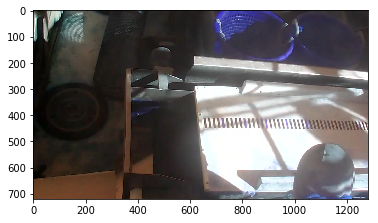

In [19]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('../extra_space/train_pics/5IxEWAV7PAWqD3x9/1754.jpg')
plt.imshow(img)
plt.show()

'../extra_space/train_pics/urdjGNWX400sL7ZT/0707.jpg'

In [13]:
df.species.unique()

array([  2.,  nan,   3.,   6.,   4.,   7.,   5.,   1.])

## Add max fish as NA back-ground class detection

In [37]:
import pandas as pd
import os
import glob 
import numpy as np
import random 
from sklearn.model_selection import train_test_split

LABELS = ['species_fourspot',
           'species_grey sole',
           'species_other', 
           'species_plaice',
           'species_summer',
           'species_windowpane',
           'species_winter']

LABELS_2_IND = {
   'species_fourspot' : 1,
   'species_grey sole' : 2,
   'species_other' : 3,
   'species_plaice' : 4,
   'species_summer': 5,
   'species_windowpane' : 6,
   'species_winter' : 7 
}

ANNOT_LIST = ['x1_new','y1_new','x2_new','y2_new','species']
REMOVE_NEGATIVE_ITEMS = 0.995
VALID_SHARE = 0.2

def change_coords(x1,y1,x2,y2,f_len):
    
    max_x = 1280
    max_y = 720
    
    x_av = (x2+x1)/2
    y_av = (y2+y1)/2
    

    if(x_av-f_len/2)>max_x:
        x1_new = max_x
    elif (x_av-f_len/2)<0:
        x1_new = 0
    else:
        x1_new=x_av-f_len/2 
        
    if(x_av+f_len/2)>max_x:
        x2_new = max_x
    else:
        x2_new=x_av+f_len/2 
        
    if(y_av-f_len/2)>max_y:
        y1_new = max_y
    elif (y_av-f_len/2)<0:
        y1_new = 0
    else:
        y1_new=y_av-f_len/2 

    if(y_av+f_len/2)>max_y:
        y2_new = max_y
    else:
        y2_new=y_av+f_len/2

    return x1_new,y1_new,x2_new,y2_new

df = pd.read_csv('../fish-video/train.csv')
df['_'] = df.apply(lambda row: change_coords(row['x1'],row['y1'],row['x2'],row['y2'],row['length']), axis=1)
df[['x1_new','y1_new','x2_new','y2_new']] = df['_'].apply(pd.Series)
del df['_']

cpt = {r:len(files) for r, d, files in os.walk('../extra_space/train_pics/')}
del cpt['../extra_space/train_pics/']
cpt = {k.split('/')[3]: v for k, v in cpt.items()}
cpt_zero = {k: v for k, v in cpt.items() if v == 0}
cpt_non_zero = {k: v for k, v in cpt.items() if v > 0}

species_list = LABELS

df['species'] = df[species_list].idxmax(axis=1).apply(lambda x: int(LABELS_2_IND[x]))
df.loc[pd.isnull(df.fish_number),'species'] = 0

df.loc[df.fish_number.isnull()==True, 'species'] = np.nan
df['path'] = df.apply(lambda row: '../extra_space/train_pics/{}/{}.jpg'.format(row['video_id'],str(row['frame']+1).zfill(4)), axis=1)

img_annots = list ( df[ (df['fish_number'].notnull()) & (~df.video_id.isin(list(cpt_zero.keys())))][ANNOT_LIST].values.tolist() )
img_paths = list ( df[ (df['fish_number'].notnull()) & (~df.video_id.isin(list(cpt_zero.keys())))]['path'].values.tolist() )    

na_frame_dict = { na_vid : 
            [df[(df['fish_number'].notnull()) & (df.video_id == na_vid)].x1_new.min(),
            df[(df['fish_number'].notnull()) & (df.video_id == na_vid)].y1_new.min(),
            df[(df['fish_number'].notnull()) & (df.video_id == na_vid)].x2_new.max(),
            df[(df['fish_number'].notnull()) & (df.video_id == na_vid)].y2_new.max()] for na_vid in na_vids 
                } 

na_vids =  list (df[ (df['fish_number'].isnull()) & (~df.video_id.isin(list(cpt_zero.keys()))) ].video_id.unique())

for na_vid in list(na_frame_dict.keys()):
    df.loc[ (df['fish_number'].isnull()) & (df.video_id == na_vid ) , ['x1_new','y1_new','x2_new','y2_new'] ] = na_frame_dict[na_vid]

df.loc[ (df['fish_number'].isnull()) & (~df.video_id.isin(list(cpt_zero.keys()))), 'species' ] = 0
img_paths_na = list ( df[ (df['fish_number'].isnull()) & (~df.video_id.isin(list(cpt_zero.keys()))) ]['path'].values.tolist() )      
img_annots_na = list ( df[ (df['fish_number'].isnull()) & (~df.video_id.isin(list(cpt_zero.keys()))) ][ANNOT_LIST].values.tolist() )


img_annots.extend(img_annots_na)
img_paths.extend(img_paths_na)

VALID_SHARE = 0.2

train_img_paths, valid_img_paths, train_img_annots, valid_img_annots = train_test_split(img_paths,img_annots, test_size=VALID_SHARE, random_state=42)

# del img_annots,img_paths,img_paths_na,img_paths_na
# del df    

In [44]:
img_annots[-3900],img_paths[-3900]

([640.7643, 335.7643, 820.2357, 515.2357, 6.0],
 '../extra_space/train_pics/z3NyIwDkOAbBqqJk/0934.jpg')

In [35]:
img_annots_na[-1]

[635.93905, 269.9921, 925.0079000000001, 563.0326, nan]

# Check submissions format

## Download the example

In [51]:
!wget https://s3.amazonaws.com/drivendata/data/48/public/submission_format_zeros.csv

--2017-10-22 13:08:27--  https://s3.amazonaws.com/drivendata/data/48/public/submission_format_zeros.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.21.149
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.21.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59051360 (56M) [text/csv]
Saving to: 'submission_format_zeros.csv'

submission_format_z 100%[===================>]  56.32M  2.62MB/s    in 54s     

2017-10-22 13:09:22 (1.04 MB/s) - 'submission_format_zeros.csv' saved [59051360/59051360]



## Pre-process predictions

In [13]:
len (data[0])

917819

In [8]:
df_sub = pd.read_csv('fish_ssd_hnm.csv')

In [11]:
df_sub.tail()

,Unnamed: 0,row_id,frame,video_id,fish_number,length,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter,xmin,xmax,ymin,ymax
918499,918499,918499,2629,zyjEx84aUTaBzbIX,0.0,0.0,0.00000,0.235778,0.118195,0.889459,0.0,0.0,0.0,1112.035400,1271.907715,270.218567,495.365936
918500,918500,918500,2630,zyjEx84aUTaBzbIX,0.0,0.0,0.00000,0.719416,0.170439,0.373250,0.0,0.0,0.0,1107.170532,1273.437622,270.304047,491.812927
918501,918501,918501,2631,zyjEx84aUTaBzbIX,0.0,0.0,0.00000,0.718885,0.169158,0.375731,0.0,0.0,0.0,1107.179688,1273.459717,270.335388,491.962799
918502,918502,918502,2632,zyjEx84aUTaBzbIX,0.0,0.0,0.00000,0.495858,0.347639,0.472969,0.0,0.0,0.0,1101.297363,1272.729980,263.941071,508.568207
918503,918503,918503,2633,zyjEx84aUTaBzbIX,0.0,0.0,0.04931,0.327005,0.423121,0.409872,0.0,0.0,0.0,1097.978394,1270.647949,312.749420,617.351807


In [14]:
df_sub = pd.read_csv('fish_ssd_v2.csv')
df_sub.tail()

,Unnamed: 0,row_id,frame,video_id,fish_number,length,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter,xmin,xmax,ymin,ymax
918499,918499,918499,2629,zyjEx84aUTaBzbIX,0.0,0.0,0.0,0.601587,0.609903,0.454837,0.0,0.017577,0.0,1025.177246,1274.540161,245.815186,680.838867
918500,918500,918500,2630,zyjEx84aUTaBzbIX,0.0,0.0,0.0,0.677086,0.725926,0.059506,0.0,0.055532,0.0,1041.122925,1274.437500,259.139496,668.416870
918501,918501,918501,2631,zyjEx84aUTaBzbIX,0.0,0.0,0.0,0.678263,0.726654,0.060785,0.0,0.056814,0.0,1040.933960,1274.340942,259.148499,668.428223
918502,918502,918502,2632,zyjEx84aUTaBzbIX,0.0,0.0,0.0,0.477318,0.819663,0.019240,0.0,0.076588,0.0,1024.630493,1271.364990,238.890503,700.113892
918503,918503,918503,2633,zyjEx84aUTaBzbIX,0.0,0.0,0.0,0.477934,0.609259,0.021915,0.0,0.120683,0.0,1051.081055,1274.075439,287.195190,707.491089


In [1]:
import pandas as pd
import numpy as np
import operator


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")
def extract_value(arr):
    try:
        return arr[0][4]
    except:
        return 0
def extract_coords(arr):
    try:
        return arr[0][4]
    except:
        return 0
def get_best_frame(index):
    
    frame_list = []
    prob_list = []

    for i in range(1,8):
        try:
            prob_list.append(data[i][index][0][4])
            frame_list.append(data[i][index][0][0:4])
        except:
            continue
    try:
        index, value = max(enumerate(prob_list), key=operator.itemgetter(1))
        return (frame_list[index])
    except:
        return (0,0,0,0)
    

LABELS = ['species_fourspot',
           'species_grey sole',
           'species_other', 
           'species_plaice',
           'species_summer',
           'species_windowpane',
           'species_winter']


broken_vids = ['P3QkoeOjxoM6pDKb','tJinkrdMMZ477RGi']

df_sub = pd.read_csv('submission_format_zeros.csv')

df_sub['xmin'] = 0
df_sub['xmax'] = 0
df_sub['ymin'] = 0
df_sub['ymax'] = 0

ids_test = [{'row_id':row[0],'frame':row[1],'video_id':row[2]} 
            for row in df_sub[(~df_sub.video_id.isin(broken_vids))][['row_id','frame','video_id']].values]

idx_list = [(idx['row_id']) for idx in ids_test]

image_paths = [('../extra_space/test_pics/{}/{}.jpg'.format(frame['video_id'],str(frame['frame']+1).zfill(4))) for frame in ids_test]

data = np.load('fish_ssd_hnm_preds.npy')

# Extract fish scores
for i,label in zip(range(1,8),LABELS):
    df_sub.loc[idx_list,label] = [(extract_value(pred)) for pred in data[i]]

# Extract best frame coords as per most likely class
frame_list = [get_best_frame(ind) for ind, x in enumerate(data[1])]    
df_sub.loc[idx_list,['xmin','ymin','xmax','ymax']] = frame_list


In [4]:
df_sub.shape

(918504, 16)

In [7]:
df_sub

,row_id,frame,video_id,fish_number,length,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter,xmin,xmax,ymin,ymax
0,0,0,01rFQwp0fqXLHg33,0.0,0.0,0.999967,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,648.838745,898.267761,311.766510,554.447205
1,1,1,01rFQwp0fqXLHg33,0.0,0.0,0.999950,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,648.953125,897.206421,312.657684,554.100769
2,2,2,01rFQwp0fqXLHg33,0.0,0.0,0.999909,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,648.660156,899.720398,313.911407,554.894226
3,3,3,01rFQwp0fqXLHg33,0.0,0.0,0.988083,0.000000,0.022014,0.000000,0.000000,0.0,0.000000,642.315979,903.239807,301.833862,560.045776
4,4,4,01rFQwp0fqXLHg33,0.0,0.0,0.981685,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,645.797058,968.330139,266.107819,601.241455
5,5,5,01rFQwp0fqXLHg33,0.0,0.0,0.975306,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,651.289551,964.497925,267.245056,598.742798
6,6,6,01rFQwp0fqXLHg33,0.0,0.0,0.975870,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,654.540710,958.664551,267.113770,594.994568
7,7,7,01rFQwp0fqXLHg33,0.0,0.0,0.913597,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,647.112671,974.604004,263.486969,599.385071
8,8,8,01rFQwp0fqXLHg33,0.0,0.0,0.961729,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,650.575684,947.974365,272.710907,595.883301
9,9,9,01rFQwp0fqXLHg33,0.0,0.0,0.985085,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,653.427246,958.722229,272.489288,590.194885


In [2]:
df_sub.to_csv('fish_ssd_hnm.csv')

In [8]:
df_sub_check = pd.read_csv('submission_format_zeros.csv')
df_sub_check.shape

(918504, 12)

In [9]:
df_sub_check.head()

,row_id,frame,video_id,fish_number,length,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter
0,0,0,01rFQwp0fqXLHg33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,01rFQwp0fqXLHg33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,01rFQwp0fqXLHg33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3,01rFQwp0fqXLHg33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,01rFQwp0fqXLHg33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Check end of files - some erros

In [1]:
!ls *csv

fish_ssd_v1.csv		       ssd_fish_thres_0.9.csv
ssd_fish_thres_0.25-Copy1.csv  ssd_fish_thres_1.5.csv
ssd_fish_thres_0.25.csv        submission_format_zeros.csv
ssd_fish_thres_0.5.csv	       test.csv
ssd_fish_thres_0.75.csv


In [35]:
import pandas as pd

df = pd.read_csv('fillna_ssd_fish_thres_0.5.csv')

In [6]:
df.head()

,row_id,frame,video_id,fish_number,length,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter
0,0,0,01rFQwp0fqXLHg33,1.0,247.106666,0.920204,0.0,0.0,0.0,0.375309,0.0,0.0
1,1,1,01rFQwp0fqXLHg33,1.0,247.106666,0.920204,0.0,0.0,0.0,0.375309,0.0,0.0
2,2,2,01rFQwp0fqXLHg33,1.0,247.106666,0.920204,0.0,0.0,0.0,0.375309,0.0,0.0
3,3,3,01rFQwp0fqXLHg33,1.0,247.106666,0.920204,0.0,0.0,0.0,0.375309,0.0,0.0
4,4,4,01rFQwp0fqXLHg33,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


In [34]:
!ls *.csv

fillna_ssd_fish_thres_0.25.csv	ssd_fish_thres_0.25.csv
fillna_ssd_fish_thres_0.5.csv	ssd_fish_thres_0.5.csv
fillna_ssd_fish_thres_0.75.csv	ssd_fish_thres_0.75.csv
fillna_ssd_fish_thres_0.9.csv	ssd_fish_thres_0.9.csv
fish_ssd_v1.csv			ssd_fish_thres_1.5.csv
fish_ssd_v2.csv			submission_format_zeros.csv
ssd_fish_thres_0.25-Copy1.csv	test.csv


In [33]:
frame_list = ['ssd_fish_thres_0.25.csv','ssd_fish_thres_0.5.csv','ssd_fish_thres_0.75.csv','ssd_fish_thres_0.9.csv']

for frame in frame_list:
    df = pd.read_csv(frame)
    df = df.fillna(value=0)
    df = df.set_index('row_id')
    df.to_csv('fillna_'+frame)

In [40]:
df[pd.isnull(df['species_windowpbane'])]

,row_id,frame,video_id,fish_number,length,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter


In [1]:
from IPython.display import FileLink
FileLink('ssd_hnm_thres_max_1_class_0.6.csv') #lists all downloadable files on server

/home/keras/notebook/ssd.pytorch/ssd_hnm_thres_max_1_class_0.6.csv

# Investigate multi-gpu / batch set-up

## Test the new implementation

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import torch 

torch.cuda.device_count()

1

In [7]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
from data import VOCroot
from data import VOC_CLASSES as labelmap
import torch.utils.data as data

from data import AnnotationTransform, VOCDetection, BaseTransform, VOC_CLASSES
from ssd import build_ssd
import pandas as pd

import sys
import os
import time
import argparse
import numpy as np
import pickle
import cv2
from data import FISHdetection
import tqdm 

from data import detection_collate
from utils.augmentations import SSDAugmentation_predict

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

ssd_dim = 300  # only support 300 now
means = (104, 117, 123)  # only support voc now

broken_vids = ['P3QkoeOjxoM6pDKb','tJinkrdMMZ477RGi']

df_sub = pd.read_csv('../fish-video/submission.csv')
df_sub.head()

df_sub['xmin'] = 0
df_sub['xmax'] = 0
df_sub['ymin'] = 0
df_sub['ymax'] = 0

ids_test = [{'row_id':row[0],'frame':row[1],'video_id':row[2]} 
            for row in df_sub[(~df_sub.video_id.isin(broken_vids))][['row_id','frame','video_id']].values]

image_paths = [('../extra_space/test_pics/{}/{}.jpg'.format(frame['video_id'],str(frame['frame']+1).zfill(4))) for frame in ids_test]
image_annots = [([0.1,0.1,0.2,0.2,1.0]) for path in image_paths]

"""
parser = argparse.ArgumentParser(description='Single Shot MultiBox Detection')
parser.add_argument('--trained_model', default='weights/ssd300_mAP_77.43_v2.pth',
                    type=str, help='Trained state_dict file path to open')
parser.add_argument('--save_folder', default='eval/', type=str,
                    help='File path to save results')
parser.add_argument('--confidence_threshold', default=0.01, type=float,
                    help='Detection confidence threshold')
parser.add_argument('--top_k', default=5, type=int,
                    help='Further restrict the number of predictions to parse')
parser.add_argument('--cuda', default=True, type=str2bool,
                    help='Use cuda to train model')
parser.add_argument('--voc_root', default=VOCroot, help='Location of VOC root directory')

args = parser.parse_args()
"""
args = type('test', (), {})()
args.cuda = True

if args.cuda and torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')


LABELS = ['species_fourspot',
           'species_grey sole',
           'species_other', 
           'species_plaice',
           'species_summer',
           'species_windowpane',
           'species_winter']

dataset_mean = (104, 117, 123)

# load net
num_classes = len(LABELS) + 1 # +1 background

args.trained_model = 'weights/fishes_w_validate_r_crop30000.pth'
args.num_workers = 4

ssd_net = build_ssd('test', 300, num_classes)
net = ssd_net

if args.cuda:
    net = torch.nn.DataParallel(ssd_net)
    cudnn.benchmark = True


ssd_net.load_weights(args.trained_model)

if args.cuda:
    net = net.cuda()
    
net.eval()

print('Finished loading model!')
# load data
dataset = FISHdetection(image_paths=image_paths,
                        image_annots=image_annots,
                        transform=SSDAugmentation_predict(ssd_dim, means),
                        dataset_name='fish_detection')
batch_size = 128

data_loader = data.DataLoader(dataset,
                              batch_size,
                              num_workers=args.num_workers,
                              shuffle=False,
                              collate_fn=detection_collate,
                              pin_memory=True)    


Loading weights into state dict...
Finished!
Finished loading model!


In [9]:
len(enumerate(data_loader))

TypeError: object of type 'enumerate' has no len()

In [7]:
dataset = FISHdetection(image_paths=image_paths,
                        image_annots=image_annots,
                        transform=SSDAugmentation_predict_fish_crop(ssd_dim, means,mode = 1),
                        dataset_name='fish_detection')
batch_size = 16

data_loader = data.DataLoader(dataset,
                              batch_size,
                              num_workers=args.num_workers,
                              shuffle=False,
                              collate_fn=detection_collate,
                              pin_memory=True) 

for i, (input, target) in enumerate(data_loader):
    input_var = torch.autograd.Variable(input, volatile=True)
    output = net(input_var)
    if i > 0:
        break
            

In [17]:
im, gt, h, w  = dataset.pull_item(0)

In [21]:
gt

array([[ 0.1,  0.1,  0.2,  0.2,  1. ]])

In [20]:
output[0,...].size()

torch.Size([8, 200, 5])

In [52]:
input.size(0)

128

In [50]:
for output_item in zip(output):
    print( output_item[0].unsqueeze(0).size())
    break

torch.Size([1, 8, 200, 5])


In [39]:
detections = output[50,...].unsqueeze(0)
gt = np.array([[ 0.1,  0.1,  0.2,  0.2,  1. ]])
j = 1

dets = detections[0, j, :]


In [42]:
mask = dets[:, 0].gt(0.).expand(5, dets.size(0)).t()  

In [43]:
mask

Variable containing:
    0     0     0     0     0
    0     0     0     0     0
    0     0     0     0     0
              ⋮               
    0     0     0     0     0
    0     0     0     0     0
    0     0     0     0     0
[torch.cuda.ByteTensor of size 200x5 (GPU 0)]

In [9]:
output.size()

torch.Size([128, 8, 200, 5])

In [8]:
input.size()

torch.Size([128, 3, 300, 300])

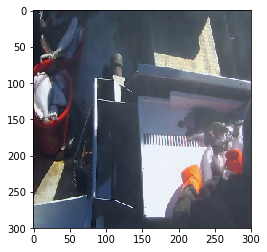

In [16]:
import matplotlib.pyplot as plt

img = input[3].cpu().numpy().astype(np.float32).transpose((1, 2, 0))
img += -img.min()
img *= (1/img.max())

plt.imshow(img)
plt.show()

In [19]:
input_var = torch.autograd.Variable(input, volatile=True)

## Write the actual script

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
from data import VOCroot
from data import VOC_CLASSES as labelmap
import torch.utils.data as data

from data import AnnotationTransform, VOCDetection, BaseTransform, VOC_CLASSES
from ssd import build_ssd
import pandas as pd

import sys
import os
import time
import argparse
import numpy as np
import pickle
import cv2
from data import FISHdetection
import tqdm 

from data import detection_collate
from utils.augmentations import SSDAugmentation_predict_fish_crop

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

ssd_dim = 300  # only support 300 now
means = (104, 117, 123)  # only support voc now

broken_vids = ['P3QkoeOjxoM6pDKb','tJinkrdMMZ477RGi']

df_sub = pd.read_csv('../fish-video/submission.csv')
df_sub.head()

df_sub['xmin'] = 0
df_sub['xmax'] = 0
df_sub['ymin'] = 0
df_sub['ymax'] = 0

ids_test = [{'row_id':row[0],'frame':row[1],'video_id':row[2]} 
            for row in df_sub[(~df_sub.video_id.isin(broken_vids))][['row_id','frame','video_id']].values]

image_paths = [('../extra_space/test_pics/{}/{}.jpg'.format(frame['video_id'],str(frame['frame']+1).zfill(4))) for frame in ids_test]
image_annots = [([0.1,0.1,0.2,0.2,1.0]) for path in image_paths]

"""
parser = argparse.ArgumentParser(description='Single Shot MultiBox Detection')
parser.add_argument('--trained_model', default='weights/ssd300_mAP_77.43_v2.pth',
                    type=str, help='Trained state_dict file path to open')
parser.add_argument('--save_folder', default='eval/', type=str,
                    help='File path to save results')
parser.add_argument('--confidence_threshold', default=0.01, type=float,
                    help='Detection confidence threshold')
parser.add_argument('--top_k', default=5, type=int,
                    help='Further restrict the number of predictions to parse')
parser.add_argument('--cuda', default=True, type=str2bool,
                    help='Use cuda to train model')
parser.add_argument('--voc_root', default=VOCroot, help='Location of VOC root directory')

args = parser.parse_args()
"""
args = type('test', (), {})()
args.cuda = True

if args.cuda and torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

LABELS = ['species_fourspot',
           'species_grey sole',
           'species_other', 
           'species_plaice',
           'species_summer',
           'species_windowpane',
           'species_winter']

dataset_mean = (104, 117, 123)

# load net
num_classes = len(LABELS) + 1 # +1 background

args.trained_model = 'weights/fishes_w_validate_r_crop30000.pth'
args.num_workers = 4

ssd_net = build_ssd('test', 300, num_classes)
net = ssd_net

if args.cuda:
    net = torch.nn.DataParallel(ssd_net)
    cudnn.benchmark = True


ssd_net.load_weights(args.trained_model)

if args.cuda:
    net = net.cuda()
    
net.eval()
print('Finished loading model!')

Loading weights into state dict...
Finished!
Finished loading model!


In [4]:
for fish_mode in (1,2,3):
    
    print('Predicting on fish mode {}'.format(fish_mode))
    
    """
    dataset = FISHdetection(image_paths=image_paths,
                            image_annots=image_annots,
                            transform=SSDAugmentation_predict_fish_crop(ssd_dim, means,mode = fish_mode),
                            dataset_name='fish_detection')
    """
    # load data
    dataset = FISHdetection(image_paths=image_paths,
                            image_annots=image_annots,
                            transform=SSDAugmentation_predict_fish_crop(ssd_dim, means,mode = fish_mode),
                            dataset_name='fish_detection')
    batch_size = 16

    data_loader = data.DataLoader(dataset,
                                  batch_size,
                                  num_workers=args.num_workers,
                                  shuffle=False,
                                  collate_fn=detection_collate,
                                  pin_memory=True) 

    
    all_boxes = [[[] for _ in range(len(ids_test))]
                 for _ in range(len(LABELS)+1)]

    with tqdm.tqdm(total=len(ids_test)) as pbar:
        # for i in range(len(ids_test)):
        # for i in range(1000):  
        i = 0
        prev_i = 0
        
        for batch_number, (input, target) in enumerate(data_loader):

            # print(batch_number)
            
            try:
                input_var = torch.autograd.Variable(input, volatile=True)
                output = net(input_var)                    

                # Because we are doing this on crops
                h, w = 720,720

                for output_item in output:

                    # print(i)
                    # im, gt, h, w = dataset.pull_item(i)
                    # x = Variable(im.unsqueeze(0))

                    # if args.cuda:
                    # x = x.cuda()

                    # detections = net(x).data
                    detections = output_item.unsqueeze(0).data
                    gt = np.array([[ 0.1,  0.1,  0.2,  0.2,  1. ]])                    

                    # skip j = 0, because it's the background class    
                    for j in range(1, detections.size(1)):
                        dets = detections[0, j, :]
                        mask = dets[:, 0].gt(0.).expand(5, dets.size(0)).t()     
                        dets = torch.masked_select(dets, mask).view(-1, 5)
                        if dets.dim() == 0:
                            continue        
                        boxes = dets[:, 1:]
                        boxes[:, 0] *= w
                        boxes[:, 2] *= w
                        boxes[:, 1] *= h
                        boxes[:, 3] *= h    
                        scores = dets[:, 0].cpu().numpy()
                        cls_dets = np.hstack((boxes.cpu().numpy(), scores[:, np.newaxis])) \
                            .astype(np.float32, copy=False)
                        all_boxes[j][i] = cls_dets

                    i += 1
                    
            except Exception as e:
                i = prev_i + input.size(0)
                prev_i += input.size(0)
                print('{} was triggered on mini batch number {}'.format(str(e), batch_number))

            pbar.update(input.size(0))
            
            if batch_number>0:
                break
    # break
    np.save('fish_ssd_fish_crop_batch_{}'.format(fish_mode),all_boxes)

Predicting on fish mode 1


  0%|          | 32/917819 [00:00<7:19:25, 34.81it/s]


Predicting on fish mode 2


  0%|          | 32/917819 [00:00<7:51:39, 32.43it/s]


Predicting on fish mode 3


  0%|          | 32/917819 [00:00<7:50:21, 32.52it/s]


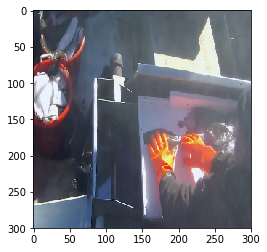

In [7]:
import matplotlib.pyplot as plt

img = input[6].cpu().numpy().astype(np.float32).transpose((1, 2, 0))
img += -img.min()
img *= (1/img.max())

plt.imshow(img)
plt.show()

In [11]:
input.size()

torch.Size([128, 3, 300, 300])

In [48]:
all_boxes[1][0:1535]

[array([[  6.54111755e+02,   3.57531372e+02,   7.78473450e+02,
           5.09546112e+02,   2.22763382e-02]], dtype=float32),
 array([[  6.54820374e+02,   3.58648071e+02,   7.78200928e+02,
           5.10304779e+02,   1.72531381e-02]], dtype=float32),
 array([[  6.54648621e+02,   3.57274506e+02,   7.78301697e+02,
           5.10958801e+02,   1.61115322e-02],
        [  6.26860046e+02,   3.38020020e+02,   7.31329163e+02,
           5.24571167e+02,   1.21758375e-02]], dtype=float32),
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 array([[  6.14191284e+02,   3.39423462e+02,   7.25288818e+02,
           5.01296783e+02,   2.17503794e-02]], dtype=float32),
 array([[  6.13158081e+02,   3.38151733e+02,   7.24403137e+02,
           5.00954407e+02,   2.72521954e-02]], dtype=float32),
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 array([[  6.54809692e+02,   3.53575958e+02,   7.79058960e+02,
           5.07595306e+02,   1.14201214e-02]], dtype=float32),
 [],
 [],
 [],
 [],
 [],
 [],
 arra

In [19]:
type(iter_item)

tuple

In [15]:
detections.size()

torch.Size([1, 3, 300, 300])

In [10]:
dets.size()

torch.Size([300, 300])

In [8]:
output

Variable containing:
( 0 , 0 ,.,.) = 
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
                   ⋮                    
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000

( 0 , 1 ,.,.) = 
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
                   ⋮                    
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000

( 0 , 2 ,.,.) = 
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
                   ⋮                    
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
    ... 

( 0 , 5 ,.,.) = 
  0.0000  0.0000  0.0000  0.0000  0.00

In [ ]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
from data import VOCroot
from data import VOC_CLASSES as labelmap
import torch.utils.data as data

from data import AnnotationTransform, VOCDetection, BaseTransform, VOC_CLASSES
from ssd import build_ssd
import pandas as pd

import sys
import os
import time
import argparse
import numpy as np
import pickle
import cv2
from data import FISHdetection
import tqdm 

from data import detection_collate
from utils.augmentations import SSDAugmentation_predict_fish_crop

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

ssd_dim = 300  # only support 300 now
means = (104, 117, 123)  # only support voc now

broken_vids = ['P3QkoeOjxoM6pDKb','tJinkrdMMZ477RGi']

df_sub = pd.read_csv('../fish-video/submission.csv')
df_sub.head()

df_sub['xmin'] = 0
df_sub['xmax'] = 0
df_sub['ymin'] = 0
df_sub['ymax'] = 0

ids_test = [{'row_id':row[0],'frame':row[1],'video_id':row[2]} 
            for row in df_sub[(~df_sub.video_id.isin(broken_vids))][['row_id','frame','video_id']].values]

image_paths = [('../extra_space/test_pics/{}/{}.jpg'.format(frame['video_id'],str(frame['frame']+1).zfill(4))) for frame in ids_test]
image_annots = [([0.1,0.1,0.2,0.2,1.0]) for path in image_paths]

"""
parser = argparse.ArgumentParser(description='Single Shot MultiBox Detection')
parser.add_argument('--trained_model', default='weights/ssd300_mAP_77.43_v2.pth',
                    type=str, help='Trained state_dict file path to open')
parser.add_argument('--save_folder', default='eval/', type=str,
                    help='File path to save results')
parser.add_argument('--confidence_threshold', default=0.01, type=float,
                    help='Detection confidence threshold')
parser.add_argument('--top_k', default=5, type=int,
                    help='Further restrict the number of predictions to parse')
parser.add_argument('--cuda', default=True, type=str2bool,
                    help='Use cuda to train model')
parser.add_argument('--voc_root', default=VOCroot, help='Location of VOC root directory')

args = parser.parse_args()
"""
args = type('test', (), {})()
args.cuda = True

LABELS = ['species_fourspot',
           'species_grey sole',
           'species_other', 
           'species_plaice',
           'species_summer',
           'species_windowpane',
           'species_winter']

dataset_mean = (104, 117, 123)

# load net
num_classes = len(LABELS) + 1 # +1 background

net = build_ssd('train', 300, num_classes)

args.trained_model = 'weights/fishes_w_validate_r_crop30000.pth'
args.num_workers = 4

net = build_ssd('test', 300, num_classes) # initialize SSD
net.load_state_dict(torch.load(args.trained_model))
net.eval()

if args.cuda:
    net = net.cuda()
    cudnn.benchmark = True
    
net.eval()

print('Finished loading model!')
# load data


# all detections are collected into:
#    all_boxes[cls][image] = N x 5 array of detections in
#    (x1, y1, x2, y2, score)

for fish_mode in (1,2,3):
    
    print('Predicting on fish mode {}'.format(fish_mode))
    
    dataset = FISHdetection(image_paths=image_paths,
                            image_annots=image_annots,
                            transform=SSDAugmentation_predict_fish_crop(ssd_dim, means,mode = fish_mode),
                            dataset_name='fish_detection')

    all_boxes = [[[] for _ in range(len(ids_test))]
                 for _ in range(len(LABELS)+1)]

    with tqdm.tqdm(total=len(ids_test)) as pbar:
        for i in range(len(ids_test)):
        # for i in range(1000):  

            try:
                im, gt, h, w = dataset.pull_item(i)
                x = Variable(im.unsqueeze(0))

                if args.cuda:
                    x = x.cuda()

                detections = net(x).data

                # skip j = 0, because it's the background class    
                for j in range(1, detections.size(1)):
                    dets = detections[0, j, :]
                    mask = dets[:, 0].gt(0.).expand(5, dets.size(0)).t()     
                    dets = torch.masked_select(dets, mask).view(-1, 5)
                    if dets.dim() == 0:
                        continue        
                    boxes = dets[:, 1:]
                    boxes[:, 0] *= w
                    boxes[:, 2] *= w
                    boxes[:, 1] *= h
                    boxes[:, 3] *= h    
                    scores = dets[:, 0].cpu().numpy()
                    cls_dets = np.hstack((boxes.cpu().numpy(), scores[:, np.newaxis])) \
                        .astype(np.float32, copy=False)
                    all_boxes[j][i] = cls_dets

            except Exception as e:
                print()
                print('{} was triggered on item {}'.format(str(e), i))

            pbar.update(1)

    np.save('fish_ssd_fish_crop_{}'.format(fish_mode),all_boxes)

## Test the preds

In [7]:
import pandas as pd
import numpy as np
import operator


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")
def extract_value(arr):
    try:
        return arr[0][4]
    except:
        return 0
def extract_coords(arr):
    try:
        return arr[0][4]
    except:
        return 0
def get_best_frame(index):
    
    frame_list = []
    prob_list = []

    for i in range(1,8):
        try:
            prob_list.append(data[i][index][0][4])
            frame_list.append(data[i][index][0][0:4])
        except:
            continue
    try:
        index, value = max(enumerate(prob_list), key=operator.itemgetter(1))
        return (frame_list[index])
    except:
        return (0,0,0,0)
    

LABELS = ['species_fourspot',
           'species_grey sole',
           'species_other', 
           'species_plaice',
           'species_summer',
           'species_windowpane',
           'species_winter']


broken_vids = ['P3QkoeOjxoM6pDKb','tJinkrdMMZ477RGi']

df_sub = pd.read_csv('submission_format_zeros.csv')

df_sub['xmin'] = 0
df_sub['xmax'] = 0
df_sub['ymin'] = 0
df_sub['ymax'] = 0

ids_test = [{'row_id':row[0],'frame':row[1],'video_id':row[2]} 
            for row in df_sub[(~df_sub.video_id.isin(broken_vids))][['row_id','frame','video_id']].values]

idx_list = [(idx['row_id']) for idx in ids_test]

image_paths = [('../extra_space/test_pics/{}/{}.jpg'.format(frame['video_id'],str(frame['frame']+1).zfill(4))) for frame in ids_test]

data = np.load('fish_ssd_fish_crop_batch_3.npy')

# Extract fish scores
for i,label in zip(range(1,8),LABELS):
    df_sub.loc[idx_list,label] = [(extract_value(pred)) for pred in data[i]]

# Extract best frame coords as per most likely class
frame_list = [get_best_frame(ind) for ind, x in enumerate(data[1])]    
df_sub.loc[idx_list,['xmin','ymin','xmax','ymax']] = frame_list

df_sub_3 = df_sub

In [8]:
df_sub_1

,row_id,frame,video_id,fish_number,length,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter,xmin,xmax,ymin,ymax
0,0,0,01rFQwp0fqXLHg33,0.0,0.0,0.022276,0.000000,0.0,0.000000,0.0,0.014065,0.000000,654.111755,778.473450,357.531372,509.546112
1,1,1,01rFQwp0fqXLHg33,0.0,0.0,0.017253,0.000000,0.0,0.000000,0.0,0.000000,0.000000,654.820374,778.200928,358.648071,510.304779
2,2,2,01rFQwp0fqXLHg33,0.0,0.0,0.016112,0.000000,0.0,0.000000,0.0,0.000000,0.000000,654.648621,778.301697,357.274506,510.958801
3,3,3,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,4,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.021892,0.000000,618.449097,721.956909,350.016235,520.147766
5,5,5,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.065709,0.000000,620.864624,721.918335,349.372711,519.381897
6,6,6,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.010665,0.000000,620.547363,722.662964,345.449280,516.727112
7,7,7,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,8,8,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.017601,0.000000,620.544739,724.387573,345.519989,518.107788
9,9,9,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
df_sub_2

,row_id,frame,video_id,fish_number,length,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter,xmin,xmax,ymin,ymax
0,0,0,01rFQwp0fqXLHg33,0.0,0.0,0.890460,0.015336,0.060984,0.000000,0.269849,0.000000,0.570313,387.800049,627.475281,314.464172,555.437500
1,1,1,01rFQwp0fqXLHg33,0.0,0.0,0.857209,0.014906,0.076296,0.000000,0.233290,0.000000,0.690843,388.096558,628.032776,313.917236,555.057861
2,2,2,01rFQwp0fqXLHg33,0.0,0.0,0.882357,0.010192,0.062868,0.000000,0.223721,0.000000,0.672470,390.312531,629.661255,315.636993,557.676147
3,3,3,01rFQwp0fqXLHg33,0.0,0.0,0.256800,0.029685,0.000000,0.027998,0.335141,0.636936,0.662489,385.357422,625.972229,313.308868,551.040833
4,4,4,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,5,5,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.033202,0.000000,386.111206,507.480164,354.287445,493.832184
6,6,6,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.199530,0.000000,386.316132,509.055542,353.248199,492.785828
7,7,7,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.327071,0.000000,386.171143,508.982513,351.557953,490.665375
8,8,8,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.091821,0.000000,386.267365,509.848755,354.194336,490.539124
9,9,9,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.022865,0.000000,387.343048,502.686401,356.551788,493.335785


In [10]:
df_sub_3

,row_id,frame,video_id,fish_number,length,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter,xmin,xmax,ymin,ymax
0,0,0,01rFQwp0fqXLHg33,0.0,0.0,0.975640,0.000000,0.066658,0.000000,0.163200,0.000000,0.390616,84.588196,328.542267,313.411072,550.152588
1,1,1,01rFQwp0fqXLHg33,0.0,0.0,0.955117,0.000000,0.111107,0.000000,0.130433,0.000000,0.621129,85.233154,329.784363,313.854126,550.288757
2,2,2,01rFQwp0fqXLHg33,0.0,0.0,0.959724,0.000000,0.075626,0.000000,0.102212,0.000000,0.514734,89.595467,330.230347,313.079010,550.310059
3,3,3,01rFQwp0fqXLHg33,0.0,0.0,0.598615,0.035661,0.013244,0.024742,0.303049,0.894543,0.361055,90.612724,332.155304,312.363892,553.159790
4,4,4,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,5,5,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,6,6,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,7,7,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.015237,0.000000,403.140686,610.530701,340.603027,554.194580
8,8,8,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,9,9,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Test new 6 crop generator and check the dataframe

In [1]:
import pandas as pd

broken_vids = ['P3QkoeOjxoM6pDKb','tJinkrdMMZ477RGi']

df_sub = pd.read_csv('../fish-video/submission.csv')
df_sub.head()

df_sub['xmin'] = 0
df_sub['xmax'] = 0
df_sub['ymin'] = 0
df_sub['ymax'] = 0

ids_test = [{'row_id':row[0],'frame':row[1],'video_id':row[2]} 
            for row in df_sub[(~df_sub.video_id.isin(broken_vids))][['row_id','frame','video_id']].values]

image_paths = [('../extra_space/test_pics/{}/{}.jpg'.format(frame['video_id'],str(frame['frame']+1).zfill(4))) for frame in ids_test]
image_annots = [([0.1,0.1,0.2,0.2,1.0]) for path in image_paths]

In [6]:
!ls ../extra_space/test_pics/7hhkT1YlQRYuMWEE/1965.jpg

../extra_space/test_pics/7hhkT1YlQRYuMWEE/1965.jpg


In [4]:
image_paths[120000:120010]

['../extra_space/test_pics/7hhkT1YlQRYuMWEE/1962.jpg',
 '../extra_space/test_pics/7hhkT1YlQRYuMWEE/1963.jpg',
 '../extra_space/test_pics/7hhkT1YlQRYuMWEE/1964.jpg',
 '../extra_space/test_pics/7hhkT1YlQRYuMWEE/1965.jpg',
 '../extra_space/test_pics/7hhkT1YlQRYuMWEE/1966.jpg',
 '../extra_space/test_pics/7hhkT1YlQRYuMWEE/1967.jpg',
 '../extra_space/test_pics/7hhkT1YlQRYuMWEE/1968.jpg',
 '../extra_space/test_pics/7hhkT1YlQRYuMWEE/1969.jpg',
 '../extra_space/test_pics/7hhkT1YlQRYuMWEE/1970.jpg',
 '../extra_space/test_pics/7hhkT1YlQRYuMWEE/1971.jpg']

In [26]:
from utils.augmentations import SSDAugmentation_predict_fish_crop6
from data import detection_collate
import torch.utils.data as data
from data import FISHdetection

ssd_dim = 300  # only support 300 now
means = (104, 117, 123)  # only support voc now

dataset = FISHdetection(image_paths=image_paths,
                        image_annots=image_annots,
                        transform=SSDAugmentation_predict_fish_crop6(ssd_dim, means,mode = 2),
                        dataset_name='fish_detection')
batch_size = 16

data_loader = data.DataLoader(dataset,
                              batch_size,
                              num_workers=2,
                              shuffle=False,
                              collate_fn=detection_collate,
                              pin_memory=True) 


            

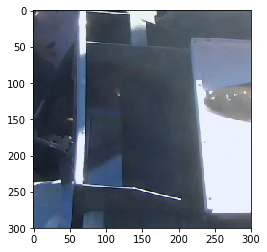

In [27]:
import matplotlib.pyplot as plt
import numpy as np

for i, (input, target) in enumerate(data_loader):
    break
    
img = input[0].cpu().numpy().astype(np.float32).transpose((1, 2, 0))
img += -img.min()
img *= (1/img.max())

plt.imshow(img)
plt.show()    

# Prepare file for 3 crop filtering

In [37]:
import pandas as pd
import numpy as np
import operator


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")
def extract_value(arr):
    try:
        return arr[0][4]
    except:
        return 0
def extract_coords(arr):
    try:
        return arr[0][4]
    except:
        return 0
def get_best_frame(index):
    
    frame_list = []
    prob_list = []

    for i in range(1,8):
        try:
            prob_list.append(data[i][index][0][4])
            frame_list.append(data[i][index][0][0:4])
        except:
            continue
    try:
        index, value = max(enumerate(prob_list), key=operator.itemgetter(1))
        return (frame_list[index])
    except:
        return (0,0,0,0)
    

LABELS = ['species_fourspot',
           'species_grey sole',
           'species_other', 
           'species_plaice',
           'species_summer',
           'species_windowpane',
           'species_winter']


broken_vids = ['P3QkoeOjxoM6pDKb','tJinkrdMMZ477RGi']

df_sub = pd.read_csv('submission_format_zeros.csv')

df_sub['xmin'] = 0
df_sub['xmax'] = 0
df_sub['ymin'] = 0
df_sub['ymax'] = 0

ids_test = [{'row_id':row[0],'frame':row[1],'video_id':row[2]} 
            for row in df_sub[(~df_sub.video_id.isin(broken_vids))][['row_id','frame','video_id']].values]

idx_list = [(idx['row_id']) for idx in ids_test]

image_paths = [('../extra_space/test_pics/{}/{}.jpg'.format(frame['video_id'],str(frame['frame']+1).zfill(4))) for frame in ids_test]

data = np.load('fish_ssd_fish_crop_batch_3.npy')

# Extract fish scores
for i,label in zip(range(1,8),LABELS):
    df_sub.loc[idx_list,label] = [(extract_value(pred)) for pred in data[i]]

# Extract best frame coords as per most likely class
frame_list = [get_best_frame(ind) for ind, x in enumerate(data[1])]    
df_sub.loc[idx_list,['xmin','ymin','xmax','ymax']] = frame_list

df_sub_3 = df_sub

In [32]:
df_sub_1.head(n=50)

,row_id,frame,video_id,fish_number,length,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter,xmin,xmax,ymin,ymax
0,0,0,01rFQwp0fqXLHg33,0.0,0.0,0.022276,0.000000,0.0,0.000000,0.0,0.014065,0.000000,654.111755,778.473450,357.531372,509.546112
1,1,1,01rFQwp0fqXLHg33,0.0,0.0,0.017253,0.000000,0.0,0.000000,0.0,0.000000,0.000000,654.820374,778.200928,358.648071,510.304779
2,2,2,01rFQwp0fqXLHg33,0.0,0.0,0.016112,0.000000,0.0,0.000000,0.0,0.000000,0.000000,654.648621,778.301697,357.274506,510.958801
3,3,3,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,4,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.021892,0.000000,618.449097,721.956909,350.016235,520.147766
5,5,5,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.065709,0.000000,620.864624,721.918335,349.372711,519.381897
6,6,6,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.010665,0.000000,620.547363,722.662964,345.449280,516.727112
7,7,7,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,8,8,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.017601,0.000000,620.544739,724.387573,345.519989,518.107788
9,9,9,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [38]:
df_sub_2.head(n=50)

,row_id,frame,video_id,fish_number,length,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter,xmin,xmax,ymin,ymax
0,0,0,01rFQwp0fqXLHg33,0.0,0.0,0.890460,0.015336,0.060984,0.000000,0.269849,0.000000,0.570313,387.800049,627.475281,314.464172,555.437500
1,1,1,01rFQwp0fqXLHg33,0.0,0.0,0.857209,0.014906,0.076296,0.000000,0.233290,0.000000,0.690843,388.096558,628.032776,313.917236,555.057861
2,2,2,01rFQwp0fqXLHg33,0.0,0.0,0.882357,0.010192,0.062868,0.000000,0.223721,0.000000,0.672470,390.312531,629.661255,315.636993,557.676147
3,3,3,01rFQwp0fqXLHg33,0.0,0.0,0.256800,0.029685,0.000000,0.027998,0.335141,0.636936,0.662489,385.357422,625.972229,313.308868,551.040833
4,4,4,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,5,5,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.033202,0.000000,386.111206,507.480164,354.287445,493.832184
6,6,6,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.199530,0.000000,386.316132,509.055542,353.248199,492.785828
7,7,7,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.327071,0.000000,386.171143,508.982513,351.557953,490.665375
8,8,8,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.091821,0.000000,386.267365,509.848755,354.194336,490.539124
9,9,9,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.022865,0.000000,387.343048,502.686401,356.551788,493.335785


In [39]:
df_sub_3.head(n=50)

,row_id,frame,video_id,fish_number,length,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter,xmin,xmax,ymin,ymax
0,0,0,01rFQwp0fqXLHg33,0.0,0.0,0.975640,0.000000,0.066658,0.000000,0.163200,0.000000,0.390616,84.588196,328.542267,313.411072,550.152588
1,1,1,01rFQwp0fqXLHg33,0.0,0.0,0.955117,0.000000,0.111107,0.000000,0.130433,0.000000,0.621129,85.233154,329.784363,313.854126,550.288757
2,2,2,01rFQwp0fqXLHg33,0.0,0.0,0.959724,0.000000,0.075626,0.000000,0.102212,0.000000,0.514734,89.595467,330.230347,313.079010,550.310059
3,3,3,01rFQwp0fqXLHg33,0.0,0.0,0.598615,0.035661,0.013244,0.024742,0.303049,0.894543,0.361055,90.612724,332.155304,312.363892,553.159790
4,4,4,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,5,5,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,6,6,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,7,7,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.015237,0.000000,403.140686,610.530701,340.603027,554.194580
8,8,8,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,9,9,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [46]:
df_max = pd.DataFrame()
df_max['df1'] = df_sub_1[LABELS].max(axis=1)
df_max['df2'] = df_sub_2[LABELS].max(axis=1)
df_max['df3'] = df_sub_3[LABELS].max(axis=1)


max_idx = df_max.idxmax(axis=1)
df_sub = pd.read_csv('submission_format_zeros.csv')


In [82]:
df_sub

,row_id,frame,video_id,fish_number,length,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter,xmin,xmax,ymin,ymax
0,0,0,01rFQwp0fqXLHg33,0.0,0.0,0.975640,0.000000,0.066658,0.000000,0.163200,0.000000,0.390616,84.588196,328.542267,313.411072,550.152588
1,1,1,01rFQwp0fqXLHg33,0.0,0.0,0.955117,0.000000,0.111107,0.000000,0.130433,0.000000,0.621129,85.233154,329.784363,313.854126,550.288757
2,2,2,01rFQwp0fqXLHg33,0.0,0.0,0.959724,0.000000,0.075626,0.000000,0.102212,0.000000,0.514734,89.595467,330.230347,313.079010,550.310059
3,3,3,01rFQwp0fqXLHg33,0.0,0.0,0.598615,0.035661,0.013244,0.024742,0.303049,0.894543,0.361055,90.612724,332.155304,312.363892,553.159790
4,4,4,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.021892,0.000000,618.449097,721.956909,350.016235,520.147766
5,5,5,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.065709,0.000000,620.864624,721.918335,349.372711,519.381897
6,6,6,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.199530,0.000000,386.316132,509.055542,353.248199,492.785828
7,7,7,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.327071,0.000000,386.171143,508.982513,351.557953,490.665375
8,8,8,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.091821,0.000000,386.267365,509.848755,354.194336,490.539124
9,9,9,01rFQwp0fqXLHg33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.022865,0.000000,387.343048,502.686401,356.551788,493.335785


In [76]:
BOXES = ['xmin',
           'xmax',
           'ymin', 
           'ymax']

In [81]:
df_sub.loc[max_idx=='df1',LABELS] = df_sub_1.loc[max_idx=='df1',LABELS]
df_sub.loc[max_idx=='df1','xmin'] = df_sub_1.loc[max_idx=='df1','xmin']
df_sub.loc[max_idx=='df1','xmax'] = df_sub_1.loc[max_idx=='df1','xmax']
df_sub.loc[max_idx=='df1','ymin'] = df_sub_1.loc[max_idx=='df1','ymin']
df_sub.loc[max_idx=='df1','ymax'] = df_sub_1.loc[max_idx=='df1','ymax']

df_sub.loc[max_idx=='df2',LABELS] = df_sub_2.loc[max_idx=='df2',LABELS]
df_sub.loc[max_idx=='df2','xmin'] = df_sub_2.loc[max_idx=='df2','xmin']
df_sub.loc[max_idx=='df2','xmax'] = df_sub_2.loc[max_idx=='df2','xmax']
df_sub.loc[max_idx=='df2','ymin'] = df_sub_2.loc[max_idx=='df2','ymin']
df_sub.loc[max_idx=='df2','ymax'] = df_sub_2.loc[max_idx=='df2','ymax']

df_sub.loc[max_idx=='df3',LABELS] = df_sub_3.loc[max_idx=='df3',LABELS]
df_sub.loc[max_idx=='df3','xmin'] = df_sub_3.loc[max_idx=='df3','xmin']
df_sub.loc[max_idx=='df3','xmax'] = df_sub_3.loc[max_idx=='df3','xmax']
df_sub.loc[max_idx=='df3','ymin'] = df_sub_3.loc[max_idx=='df3','ymin']
df_sub.loc[max_idx=='df3','ymax'] = df_sub_3.loc[max_idx=='df3','ymax']

In [83]:
df_sub.to_csv('fish_crop_preds.csv')

# Run predictions on the train dataset to fit the threshold param better

In [19]:
import os
import glob

cpt = {r:len(files) for r, d, files in os.walk('../extra_space/train_pics/')}
del cpt['../extra_space/train_pics/']
cpt = {k.split('/')[3]: v for k, v in cpt.items()}
cpt_zero = {k: v for k, v in cpt.items() if v == 0}
cpt_non_zero = {k: v for k, v in cpt.items() if v > 0}

image_paths = []

for vid in cpt_non_zero.keys():
    path = '../extra_space/train_pics/'+vid+'/*'
    g = glob.glob(path)
    image_paths.extend(g)
    
image_annots = [([0.1,0.1,0.2,0.2,1.0]) for path in image_paths]    

In [18]:
len(image_paths)

1732319

In [21]:
len(image_paths)

1732319

# Find out the best param for post-processing

## Pre-process the data

In [43]:
import pandas as pd
import numpy as np
import operator
import glob

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")
def extract_value(arr):
    try:
        return arr[0][4]
    except:
        return 0
def extract_coords(arr):
    try:
        return arr[0][4]
    except:
        return 0
def get_best_frame(index):
    
    frame_list = []
    prob_list = []

    for i in range(1,8):
        try:
            prob_list.append(data[i][index][0][4])
            frame_list.append(data[i][index][0][0:4])
        except:
            continue
    try:
        index, value = max(enumerate(prob_list), key=operator.itemgetter(1))
        return (frame_list[index])
    except:
        return (0,0,0,0)
    

LABELS = ['species_fourspot',
           'species_grey sole',
           'species_other', 
           'species_plaice',
           'species_summer',
           'species_windowpane',
           'species_winter']


cpt = {r:len(files) for r, d, files in os.walk('../extra_space/train_pics/')}
del cpt['../extra_space/train_pics/']
cpt = {k.split('/')[3]: v for k, v in cpt.items()}
cpt_zero = {k: v for k, v in cpt.items() if v == 0}
cpt_non_zero = {k: v for k, v in cpt.items() if v > 0}

image_paths = []

for vid in cpt_non_zero.keys():
    path = '../extra_space/train_pics/'+vid+'/*'
    g = glob.glob(path)
    image_paths.extend(g)
 

df_sub = pd.DataFrame()
df_sub['path'] = image_paths
df_sub['video_id'] = df_sub['path'].apply(lambda x: x.split('/')[3])

for label in LABELS:
    df_sub[label] = 0

df_sub['xmin'] = 0
df_sub['xmax'] = 0
df_sub['ymin'] = 0
df_sub['ymax'] = 0

data = np.load('fish_ssd_crop_train_3.npy')

# Extract fish scores
for i,label in zip(range(1,8),LABELS):
    df_sub.loc[:,label] = [(extract_value(pred)) for pred in data[i]]

# Extract best frame coords as per most likely class
frame_list = [get_best_frame(ind) for ind, x in enumerate(data[1])]    
df_sub.loc[:,['xmin','ymin','xmax','ymax']] = frame_list

df_sub_3 = df_sub


In [40]:
df_sub_1

,path,video_id,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter,xmin,xmax,ymin,ymax
0,../extra_space/train_pics/wsn28Ja8QTnhanV6/000...,wsn28Ja8QTnhanV6,0.000000,0.000000,0.012887,0.000000,0.000000,0.000000,0.000000,22.085417,215.351303,348.525024,615.894470
1,../extra_space/train_pics/wsn28Ja8QTnhanV6/002...,wsn28Ja8QTnhanV6,0.000000,0.041793,0.022453,0.000000,0.000000,0.831838,0.038625,402.079742,608.558228,289.405640,526.967651
2,../extra_space/train_pics/wsn28Ja8QTnhanV6/001...,wsn28Ja8QTnhanV6,0.000000,0.000000,0.094467,0.000000,0.028756,0.000000,0.000000,38.582363,249.955322,266.015350,577.227844
3,../extra_space/train_pics/wsn28Ja8QTnhanV6/000...,wsn28Ja8QTnhanV6,0.000000,0.021129,0.010751,0.000000,0.000000,0.459009,0.011681,402.383759,599.892822,290.194061,526.836548
4,../extra_space/train_pics/wsn28Ja8QTnhanV6/001...,wsn28Ja8QTnhanV6,0.000000,0.000000,0.029296,0.000000,0.000000,0.046067,0.038071,651.886230,717.217957,333.086151,460.368164
5,../extra_space/train_pics/wsn28Ja8QTnhanV6/001...,wsn28Ja8QTnhanV6,0.000000,0.000000,0.014633,0.000000,0.000000,0.000000,0.000000,32.685184,242.983444,278.036072,565.751343
6,../extra_space/train_pics/wsn28Ja8QTnhanV6/000...,wsn28Ja8QTnhanV6,0.000000,0.048904,0.014097,0.000000,0.000000,0.799815,0.060702,401.673553,607.617310,288.054108,525.083923
7,../extra_space/train_pics/wsn28Ja8QTnhanV6/001...,wsn28Ja8QTnhanV6,0.000000,0.040552,0.041587,0.000000,0.014258,0.868588,0.046330,399.503235,606.549744,287.644562,526.032349
8,../extra_space/train_pics/wsn28Ja8QTnhanV6/001...,wsn28Ja8QTnhanV6,0.000000,0.031724,0.032073,0.000000,0.011128,0.838655,0.024883,400.788239,607.017517,287.497437,524.833557
9,../extra_space/train_pics/wsn28Ja8QTnhanV6/002...,wsn28Ja8QTnhanV6,0.000000,0.054420,0.014088,0.000000,0.000000,0.624228,0.048933,400.617584,604.637024,287.150421,524.724426


In [42]:
df_sub_2

,path,video_id,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter,xmin,xmax,ymin,ymax
0,../extra_space/train_pics/wsn28Ja8QTnhanV6/000...,wsn28Ja8QTnhanV6,0.013379,0.000000,0.000000,0.024372,0.0,0.014634,0.000000,604.338135,728.643982,321.809937,486.495331
1,../extra_space/train_pics/wsn28Ja8QTnhanV6/002...,wsn28Ja8QTnhanV6,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.012123,421.562195,549.663452,324.005585,462.753143
2,../extra_space/train_pics/wsn28Ja8QTnhanV6/001...,wsn28Ja8QTnhanV6,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,../extra_space/train_pics/wsn28Ja8QTnhanV6/000...,wsn28Ja8QTnhanV6,0.013354,0.000000,0.000000,0.000000,0.0,0.000000,0.470405,445.715576,587.818787,321.239166,471.310760
4,../extra_space/train_pics/wsn28Ja8QTnhanV6/001...,wsn28Ja8QTnhanV6,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.999941,379.445282,628.105591,277.978607,524.909607
5,../extra_space/train_pics/wsn28Ja8QTnhanV6/001...,wsn28Ja8QTnhanV6,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,384.868073,620.878601,287.209106,525.753967
6,../extra_space/train_pics/wsn28Ja8QTnhanV6/000...,wsn28Ja8QTnhanV6,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.689959,420.269928,554.564026,324.958557,471.262543
7,../extra_space/train_pics/wsn28Ja8QTnhanV6/001...,wsn28Ja8QTnhanV6,0.000000,0.000000,0.010351,0.000000,0.0,0.000000,0.017152,488.580902,620.598511,314.342407,471.738525
8,../extra_space/train_pics/wsn28Ja8QTnhanV6/001...,wsn28Ja8QTnhanV6,0.023725,0.000000,0.000000,0.000000,0.0,0.055674,0.201022,443.044800,580.462891,317.652130,463.370026
9,../extra_space/train_pics/wsn28Ja8QTnhanV6/002...,wsn28Ja8QTnhanV6,0.030599,0.000000,0.000000,0.000000,0.0,0.061235,0.536083,442.560547,583.698181,318.204712,466.752472


In [44]:
df_sub_3

,path,video_id,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter,xmin,xmax,ymin,ymax
0,../extra_space/train_pics/wsn28Ja8QTnhanV6/000...,wsn28Ja8QTnhanV6,0.250045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,190.977020,309.682281,364.903290,498.745422
1,../extra_space/train_pics/wsn28Ja8QTnhanV6/002...,wsn28Ja8QTnhanV6,0.769003,0.039225,0.017369,0.094129,0.000000,0.193773,0.000000,442.045563,607.496399,336.946533,503.542480
2,../extra_space/train_pics/wsn28Ja8QTnhanV6/001...,wsn28Ja8QTnhanV6,0.023754,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,154.717667,286.619781,347.024231,492.726746
3,../extra_space/train_pics/wsn28Ja8QTnhanV6/000...,wsn28Ja8QTnhanV6,0.098952,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163.794357,277.194031,367.467438,496.885345
4,../extra_space/train_pics/wsn28Ja8QTnhanV6/001...,wsn28Ja8QTnhanV6,0.262549,0.000000,0.000000,0.000000,0.000000,0.793544,0.000000,283.449493,479.023132,323.388794,538.130371
5,../extra_space/train_pics/wsn28Ja8QTnhanV6/001...,wsn28Ja8QTnhanV6,0.999970,0.000000,0.000000,0.000000,0.023336,0.000000,0.000000,133.398117,377.783295,306.006500,545.452820
6,../extra_space/train_pics/wsn28Ja8QTnhanV6/000...,wsn28Ja8QTnhanV6,0.211045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,463.714233,664.715332,330.115204,554.798523
7,../extra_space/train_pics/wsn28Ja8QTnhanV6/001...,wsn28Ja8QTnhanV6,0.893663,0.000000,0.000000,0.000000,0.957009,0.000000,0.000000,145.169998,403.403198,304.074341,568.895264
8,../extra_space/train_pics/wsn28Ja8QTnhanV6/001...,wsn28Ja8QTnhanV6,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,166.172806,348.856262,366.514557,545.274414
9,../extra_space/train_pics/wsn28Ja8QTnhanV6/002...,wsn28Ja8QTnhanV6,0.253512,0.000000,0.000000,0.000000,0.000000,0.138979,0.000000,156.047577,279.169250,348.215210,479.798615


In [45]:
df_max = pd.DataFrame()
df_max['df1'] = df_sub_1[LABELS].max(axis=1)
df_max['df2'] = df_sub_2[LABELS].max(axis=1)
df_max['df3'] = df_sub_3[LABELS].max(axis=1)


max_idx = df_max.idxmax(axis=1)

df_sub = pd.DataFrame()
df_sub['path'] = image_paths
df_sub['video_id'] = df_sub['path'].apply(lambda x: x.split('/')[3])

for label in LABELS:
    df_sub[label] = 0

df_sub['xmin'] = 0
df_sub['xmax'] = 0
df_sub['ymin'] = 0
df_sub['ymax'] = 0

df_sub.loc[max_idx=='df1',LABELS] = df_sub_1.loc[max_idx=='df1',LABELS]
df_sub.loc[max_idx=='df1','xmin'] = df_sub_1.loc[max_idx=='df1','xmin']
df_sub.loc[max_idx=='df1','xmax'] = df_sub_1.loc[max_idx=='df1','xmax']
df_sub.loc[max_idx=='df1','ymin'] = df_sub_1.loc[max_idx=='df1','ymin']
df_sub.loc[max_idx=='df1','ymax'] = df_sub_1.loc[max_idx=='df1','ymax']

df_sub.loc[max_idx=='df2',LABELS] = df_sub_2.loc[max_idx=='df2',LABELS]
df_sub.loc[max_idx=='df2','xmin'] = df_sub_2.loc[max_idx=='df2','xmin']
df_sub.loc[max_idx=='df2','xmax'] = df_sub_2.loc[max_idx=='df2','xmax']
df_sub.loc[max_idx=='df2','ymin'] = df_sub_2.loc[max_idx=='df2','ymin']
df_sub.loc[max_idx=='df2','ymax'] = df_sub_2.loc[max_idx=='df2','ymax']

df_sub.loc[max_idx=='df3',LABELS] = df_sub_3.loc[max_idx=='df3',LABELS]
df_sub.loc[max_idx=='df3','xmin'] = df_sub_3.loc[max_idx=='df3','xmin']
df_sub.loc[max_idx=='df3','xmax'] = df_sub_3.loc[max_idx=='df3','xmax']
df_sub.loc[max_idx=='df3','ymin'] = df_sub_3.loc[max_idx=='df3','ymin']
df_sub.loc[max_idx=='df3','ymax'] = df_sub_3.loc[max_idx=='df3','ymax']

In [47]:
df_sub.to_csv('train_preds_max.csv')

## Select a number of random videos

In [2]:
import pandas as pd

df_train = pd.read_csv('../fish-video/train.csv')
df_train

,row_id,video_id,frame,fish_number,length,x1,y1,x2,y2,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter
0,0,00WK7DR6FyPZ5u3A,0,1.0,165.3028,766.0,531.0,659.0,405.0,0,1,0,0,0,0,0
1,1,00WK7DR6FyPZ5u3A,18,2.0,176.5814,776.0,540.0,661.0,406.0,0,1,0,0,0,0,0
2,2,00WK7DR6FyPZ5u3A,41,3.0,172.4297,772.0,538.0,666.0,402.0,0,1,0,0,0,0,0
3,3,00WK7DR6FyPZ5u3A,63,4.0,166.6433,770.0,531.0,667.0,400.0,0,1,0,0,0,0,0
4,4,00WK7DR6FyPZ5u3A,82,5.0,177.8820,777.0,544.0,666.0,405.0,0,1,0,0,0,0,0
5,5,00WK7DR6FyPZ5u3A,100,6.0,161.4435,763.0,527.0,655.0,407.0,0,1,0,0,0,0,0
6,6,00WK7DR6FyPZ5u3A,115,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
7,7,00WK7DR6FyPZ5u3A,123,7.0,181.6865,777.0,543.0,660.0,404.0,0,1,0,0,0,0,0
8,8,00WK7DR6FyPZ5u3A,142,8.0,206.4655,789.0,563.0,661.0,401.0,0,1,0,0,0,0,0
9,9,00WK7DR6FyPZ5u3A,160,9.0,197.0913,783.0,556.0,660.0,402.0,0,1,0,0,0,0,0


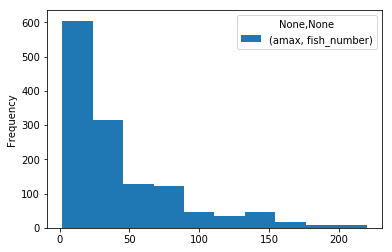

In [65]:
%matplotlib inline

pd.pivot_table(df_train,
               index=["video_id"],
               values=["fish_number"],
               aggfunc=[np.max],
               fill_value=0).plot(kind='hist')


In [60]:
from random import shuffle


rand_vids = list(df_train.video_id.unique())
shuffle(rand_vids)
rand_vids = rand_vids[0:100]

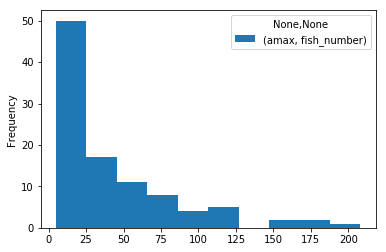

In [64]:
%matplotlib inline

pd.pivot_table(df_train[df_train.video_id.isin(rand_vids)],
               index=["video_id"],
               values=["fish_number"],
               aggfunc=[np.max],
               fill_value=0).plot(kind='hist')


In [62]:
import pickle

with open("rand_vids.txt", "wb") as fp:   #Pickling
    pickle.dump(rand_vids, fp)

In [63]:
!ls rand_vids.txt

rand_vids.txt


In [71]:
len(rand_vids)

100

In [4]:
import pickle

with open("rand_vids.txt", "rb") as fp:   # Unpickling
    rand_vids = pickle.load(fp)

In [72]:
df_sub.shape

(1732319, 13)

In [74]:
df_sub[df_sub.video_id.isin(rand_vids)].shape

(141226, 13)

In [6]:
import pickle
import numpy as np

with open("rand_vids.txt", "rb") as fp:   # Unpickling
    rand_vids = pickle.load(fp)

df_sub = pd.read_csv('train_preds_max.csv')
df_sub = df_sub[df_sub.video_id.isin(rand_vids)]

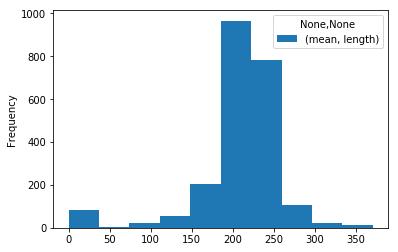

In [11]:
%matplotlib inline

pd.pivot_table(df_train[df_train.video_id.isin(rand_vids)],
               index=["frame"],
               values=["length"],
               aggfunc=[np.mean],
               fill_value=0).plot(kind='hist')

In [13]:
df_check.columns.values

array(['Unnamed: 0', 'index', 'Unnamed: 0.1', 'path', 'video_id',
       'species_fourspot', 'species_grey sole', 'species_other',
       'species_plaice', 'species_summer', 'species_windowpane',
       'species_winter', 'fish_number', 'length'], dtype=object)

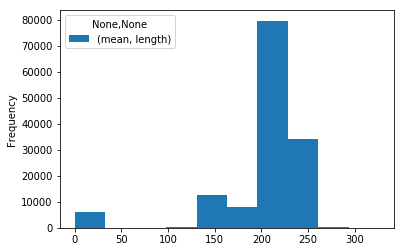

In [14]:
df_check = pd.read_csv('ssd_fish_train_0.5.csv')

pd.pivot_table(df_check[df_check.video_id.isin(rand_vids)],
               index=["path"],
               values=["length"],
               aggfunc=[np.mean],
               fill_value=0).plot(kind='hist')

## Do the check

In [96]:
print('Processing threshold {}'.format(0.5))

with open("rand_vids.txt", "rb") as fp:   # Unpickling
    rand_vids = pickle.load(fp)

df_sub = pd.read_csv('train_preds_max.csv')
df_sub = df_sub.sort_values('path')
df_sub = df_sub[df_sub.video_id.isin(rand_vids)]

Processing threshold 0.5


In [103]:
df_sub.path[0:10]

0    ../extra_space/train_pics/0agWG0Rmk8SIeSsf/000...
1    ../extra_space/train_pics/0agWG0Rmk8SIeSsf/000...
2    ../extra_space/train_pics/0agWG0Rmk8SIeSsf/000...
3    ../extra_space/train_pics/0agWG0Rmk8SIeSsf/000...
4    ../extra_space/train_pics/0agWG0Rmk8SIeSsf/000...
5    ../extra_space/train_pics/0agWG0Rmk8SIeSsf/000...
6    ../extra_space/train_pics/0agWG0Rmk8SIeSsf/000...
7    ../extra_space/train_pics/0agWG0Rmk8SIeSsf/000...
8    ../extra_space/train_pics/0agWG0Rmk8SIeSsf/000...
9    ../extra_space/train_pics/0agWG0Rmk8SIeSsf/001...
Name: path, dtype: object

In [100]:
df_sub = df_sub.reset_index()

In [101]:
df_sub.loc[0:0+5,'xmin'].sum()

1689.0146598815918

In [98]:
df_sub

,Unnamed: 0,path,video_id,species_fourspot,species_grey sole,species_other,species_plaice,species_summer,species_windowpane,species_winter,xmin,xmax,ymin,ymax
126892,126892,../extra_space/train_pics/0agWG0Rmk8SIeSsf/000...,0agWG0Rmk8SIeSsf,0.045145,0.000000,0.297751,0.000000,0.026719,0.082779,0.000000,61.709175,297.672028,285.603119,555.331238
126052,126052,../extra_space/train_pics/0agWG0Rmk8SIeSsf/000...,0agWG0Rmk8SIeSsf,0.088759,0.000000,0.479341,0.000000,0.030055,0.104660,0.000000,59.046482,298.456726,284.583801,553.111084
125300,125300,../extra_space/train_pics/0agWG0Rmk8SIeSsf/000...,0agWG0Rmk8SIeSsf,0.000000,0.000000,0.000000,0.010556,0.000000,0.000000,0.000000,388.392792,509.492126,399.957458,542.340393
126377,126377,../extra_space/train_pics/0agWG0Rmk8SIeSsf/000...,0agWG0Rmk8SIeSsf,0.015957,0.000000,0.211201,0.000000,0.195461,0.998426,0.000000,399.053741,615.961548,290.751343,528.069214
124964,124964,../extra_space/train_pics/0agWG0Rmk8SIeSsf/000...,0agWG0Rmk8SIeSsf,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,399.630219,629.557129,326.678131,551.285217
125051,125051,../extra_space/train_pics/0agWG0Rmk8SIeSsf/000...,0agWG0Rmk8SIeSsf,0.000000,0.000000,0.000000,0.839383,0.000000,0.000000,0.000000,381.182251,511.062988,402.402466,537.337708
125461,125461,../extra_space/train_pics/0agWG0Rmk8SIeSsf/000...,0agWG0Rmk8SIeSsf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
125715,125715,../extra_space/train_pics/0agWG0Rmk8SIeSsf/000...,0agWG0Rmk8SIeSsf,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,376.469116,616.758667,285.368286,523.971313
126197,126197,../extra_space/train_pics/0agWG0Rmk8SIeSsf/000...,0agWG0Rmk8SIeSsf,0.021476,0.000000,0.000000,0.000000,0.000000,0.999888,0.083301,464.193573,669.652405,317.118408,537.380981
126370,126370,../extra_space/train_pics/0agWG0Rmk8SIeSsf/001...,0agWG0Rmk8SIeSsf,0.038414,0.000000,0.369652,0.000000,0.171440,0.253546,0.000000,55.606602,285.664154,272.551697,552.076355


In [93]:
df_sub = df_sub.sort_values('path')

In [83]:
!ls ssd_fish_train_*

ssd_fish_train_0.1.csv	ssd_fish_train_0.6.csv	 ssd_fish_train_0.925.csv
ssd_fish_train_0.2.csv	ssd_fish_train_0.7.csv	 ssd_fish_train_0.95.csv
ssd_fish_train_0.3.csv	ssd_fish_train_0.75.csv  ssd_fish_train_0.975.csv
ssd_fish_train_0.4.csv	ssd_fish_train_0.8.csv	 ssd_fish_train_0.99.csv
ssd_fish_train_0.5.csv	ssd_fish_train_0.9.csv


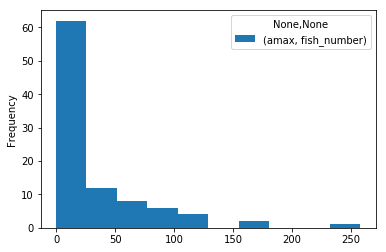

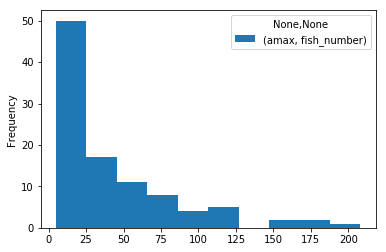

1676.4421052631578

In [178]:
import matplotlib.pyplot as plt

df_check = pd.read_csv('ssd_fish_train_0.5.csv')

fig = plt.figure()

pd.pivot_table(df_check,
               index=["video_id"],
               values=["fish_number"],
               aggfunc=[np.max],
               fill_value=0).plot(kind='hist')

pd.pivot_table(df_train[df_train.video_id.isin(rand_vids)],
               index=["video_id"],
               values=["fish_number"],
               aggfunc=[np.max],
               fill_value=0).plot(kind='hist')

plt.show()

gt_table = pd.pivot_table(df_train[df_train.video_id.isin(rand_vids)],
               index=["video_id"],
               values=["fish_number"],
               aggfunc=[np.max],
               fill_value=0)

gt_table.columns = gt_table.columns.get_level_values(0)
gt_table = gt_table.reset_index()
table = pd.pivot_table(df_check,
               index=["video_id"],
               values=["fish_number"],
               aggfunc=[np.max],
               fill_value=0)

table.columns = table.columns.get_level_values(0)
table = table.reset_index()
check = pd.merge(table,gt_table,on='video_id')
check['diff'] = (check['amax_x']-check['amax_y'])**2
check['diff'].sum(axis=0)/check.shape[0]

In [116]:
gt_table.reset_index().keys()

MultiIndex(levels=[['amax', 'video_id'], ['fish_number', '']],
           labels=[[1, 0], [1, 0]])

,video_id,amax
0,0agWG0Rmk8SIeSsf,74
1,1DNPTfbb4A9cinjB,15
2,1m4CexFtjZkfB7Ok,43
3,2OsFoE12GHMAYf3G,11
4,36DZly7KCdHA1ARL,6
5,37JFPZxnRinGHLC1,7
6,3ZztYZ5HAZMPXbAS,11
7,3yal2cCgymirTCJR,43
8,4bZWNDwQP3mQv0dh,13
9,6TfISXdNqbANLzpI,187


,video_id,amax
0,0agWG0Rmk8SIeSsf,25
1,1DNPTfbb4A9cinjB,4
2,1m4CexFtjZkfB7Ok,4
3,2OsFoE12GHMAYf3G,1
4,36DZly7KCdHA1ARL,3
5,37JFPZxnRinGHLC1,3
6,3ZztYZ5HAZMPXbAS,1
7,3yal2cCgymirTCJR,10
8,4bZWNDwQP3mQv0dh,1
9,6TfISXdNqbANLzpI,25


,video_id,amax_x,amax_y
0,0agWG0Rmk8SIeSsf,25,74
1,1DNPTfbb4A9cinjB,4,15
2,1m4CexFtjZkfB7Ok,4,43
3,2OsFoE12GHMAYf3G,1,11
4,36DZly7KCdHA1ARL,3,6
5,37JFPZxnRinGHLC1,3,7
6,3ZztYZ5HAZMPXbAS,1,11
7,3yal2cCgymirTCJR,10,43
8,4bZWNDwQP3mQv0dh,1,13
9,6TfISXdNqbANLzpI,25,187


In [122]:
table = table.reset_index()
table['amax_gt'] = gt_table['amax']
table

,video_id,amax,amax_gt
0,0agWG0Rmk8SIeSsf,25,NaN
1,1DNPTfbb4A9cinjB,4,NaN
2,1m4CexFtjZkfB7Ok,4,NaN
3,2OsFoE12GHMAYf3G,1,NaN
4,36DZly7KCdHA1ARL,3,NaN
5,37JFPZxnRinGHLC1,3,NaN
6,3ZztYZ5HAZMPXbAS,1,NaN
7,3yal2cCgymirTCJR,10,NaN
8,4bZWNDwQP3mQv0dh,1,NaN
9,6TfISXdNqbANLzpI,25,NaN
